In [1]:
import warnings
warnings.filterwarnings('ignore')

# 데이터 읽기를 위한 라이브러리
import numpy as np
np.random.seed(0)
import pandas as pd
import gc, os, time
import scipy as sp
from pandas import DataFrame, Series
from datetime import datetime, date, timedelta
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn import decomposition

# 탐색적 데이터 분석을 위한 라이브러리
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import skew, norm, probplot, boxcox

# 모델링을 위한 라이브러리
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import mutual_info_regression, VarianceThreshold

import pickle

pd.set_option('display.max_columns',999)

In [2]:
# 학습용 데이터 
train_sensor = pd.read_csv('train_sensor.csv')
train_quality = pd.read_csv('train_quality.csv')
# 평가용 데이터 
predict_sensor = pd.read_csv('predict_sensor.csv')

In [3]:
def make_dataset(X, y=None):
    
    # -----------------------------------
    # train_sensor (X 인자)
    # -----------------------------------
    ''' column을 param_alias 로만 pivot table 만들기. '''
    df_X = X.copy()
    df_X = df_X.sort_values(by='end_time',ascending=True)
    df_X['step_id'] = df_X['step_id'].apply(lambda x: str(x).zfill(2))
    # step_id 와 param_alias 를 결합한 임시 컬럼 step_param 을 생성합니다. ex. 17_EPD_para4
    df_X['step_param'] = df_X[['step_id', 'param_alias']].apply(lambda x: '_'.join(x), axis=1)
    df_X_tmp = df_X.pivot_table(index = ['module_name','key_val'], columns = 'step_param', values='mean_val', aggfunc='sum')
    # 데이터 통합을 위해 인덱스를 key_val 로 재설정합니다. 
    df_X_tmp = df_X_tmp.reset_index(level=[0, 1])
    df_X_tmp.set_index('key_val', inplace=True)

    # -----------------------------------
    # 시간 데이터 
    # -----------------------------------
    ''' step별 end_time을 column으로 pivot table 만들기 '''
    df_X['end_time_tmp'] = df_X.apply(lambda x: x['step_id'] + '_end_time', axis=1)
    df_X['end_time'] = pd.to_datetime(df_X['end_time'])
    # end_time 은 센서 데이터가 각 para 별로 서버에 도달한 시간으로 스텝 내 오차가 발생할 수 있습니다. 동일 스텝 구간내 공정 완료 시간이 다른 경우, min 함수를 사용하여 최초 수집된 time을 가져옵니다.
    df_time_tmp = df_X.pivot_table(index = ['key_val'], columns = 'end_time_tmp', values='end_time', aggfunc=lambda x : min(x.unique()))
    df_time_tmp = df_time_tmp.reset_index()
    df_time_tmp.set_index('key_val', inplace=True)

    # -----------------------------------
    # train_quality (y 인자)
    # -----------------------------------

    if y is None : # 평가용 데이터 
        col_target = []
        col_idx = ['module_name', 'key_val']
        df_complete = pd.concat([df_X_tmp, df_time_tmp], axis=1).reset_index()
        df_complete.rename(columns={'index':'key_val'},inplace=True)
    else : # 학습용 데이터 
        df_y = y.copy()
        df_y.set_index('key_val', inplace=True)
        col_target = ['y']
        col_idx = ['module_name', 'key_val', 'end_dt_tm']
        # 센서 데이터, 시간데이터, 품질지표에 대하여 인덱스(key_val)기준으로 데이터프레임을 통합합니다.
        df_complete = pd.concat([df_X_tmp, df_time_tmp, df_y], axis=1).reset_index()
        # 컬럼 이름을 변경합니다.  
        df_complete.rename(columns={'msure_val':'y'}, inplace=True)
        df_complete.rename(columns={'index':'key_val'},inplace=True)


    # 컬럼 순서를 정렬합니다. 
    col_feats = df_X['step_param'].unique().tolist()
    col_feats.sort()
    col_time = [s for s in df_complete.columns.tolist() if "_end_time" in s]
    col_all = col_idx + col_target + col_feats + col_time
    df_complete = df_complete[col_all]
    # 처음 step이 시작된 시점을 기준으로 다시 정렬(APC value를 먹고 들어가는 값을 기준으로 정렬하고 싶었음.)
    df_complete = df_complete.set_index(['module_name','key_val','04_end_time']).sort_index(level=[0,2,1],ascending=True).reset_index()
    df_complete = df_complete[col_all]
    
    # 컬럼을 소문자로 변경합니다. 
    df_complete.columns = df_complete.columns.str.lower()

    return df_complete

In [4]:
# 학습용 데이터 
train = make_dataset(train_sensor, train_quality)
# 평가용 데이터 
predict = make_dataset(predict_sensor)

In [5]:
train.head()

,module_name,key_val,end_dt_tm,y,04_efem_para2,04_efem_para25,04_efem_para78,04_epd_para4,04_epd_para40,04_epd_para63,04_epd_para80,04_esc_para84,04_esc_para94,04_fr_para28,04_fr_para35,04_fr_para61,04_fr_para69,04_gas_para10,04_gas_para13,04_gas_para15,04_gas_para19,04_gas_para21,04_gas_para26,04_gas_para27,04_gas_para33,04_gas_para36,04_gas_para39,04_gas_para46,04_gas_para48,04_gas_para50,04_gas_para51,04_gas_para52,04_gas_para59,04_gas_para6,04_gas_para70,04_gas_para71,04_gas_para73,04_gas_para74,04_gas_para85,04_he_para1,04_he_para22,04_he_para88,04_he_para95,04_hv_para3,04_hv_para45,04_hv_para47,04_hv_para56,04_position_para72,04_power_para14,04_power_para49,04_power_para57,04_power_para68,04_power_para76,04_power_para82,04_pressure_para91,04_temp_para11,04_temp_para12,04_temp_para17,04_temp_para18,04_temp_para20,04_temp_para23,04_temp_para24,04_temp_para32,04_temp_para38,04_temp_para53,04_temp_para54,04_temp_para55,04_temp_para58,04_temp_para60,04_temp_para65,04_temp_para66,04_temp_para79,04_temp_para86,04_temp_para87,04_temp_para92,04_temp_para93,04_time_para16,04_time_para29,04_time_para30,04_time_para34,04_time_para37,04_time_para41,04_time_para42,04_time_para43,04_time_para44,04_time_para5,04_time_para62,04_time_para64,04_time_para67,04_time_para7,04_time_para75,04_time_para77,04_time_para8,04_time_para81,04_time_para83,04_time_para89,04_time_para9,04_time_para90,04_tmp_para31,06_efem_para2,06_efem_para25,06_efem_para78,06_epd_para4,06_epd_para40,06_epd_para63,06_epd_para80,06_esc_para84,06_esc_para94,06_fr_para28,06_fr_para35,06_fr_para61,06_fr_para69,06_gas_para10,06_gas_para13,06_gas_para15,06_gas_para19,06_gas_para21,06_gas_para26,06_gas_para27,06_gas_para33,06_gas_para36,06_gas_para39,06_gas_para46,06_gas_para48,06_gas_para50,06_gas_para51,06_gas_para52,06_gas_para59,06_gas_para6,06_gas_para70,06_gas_para71,06_gas_para73,06_gas_para74,06_gas_para85,06_he_para1,06_he_para22,06_he_para88,06_he_para95,06_hv_para3,06_hv_para45,06_hv_para47,06_hv_para56,06_position_para72,06_power_para14,06_power_para49,06_power_para57,06_power_para68,06_power_para76,06_power_para82,06_pressure_para91,06_temp_para11,06_temp_para12,06_temp_para17,06_temp_para18,06_temp_para20,06_temp_para23,06_temp_para24,06_temp_para32,06_temp_para38,06_temp_para53,06_temp_para54,06_temp_para55,06_temp_para58,06_temp_para60,06_temp_para65,06_temp_para66,06_temp_para79,06_temp_para86,06_temp_para87,06_temp_para92,06_temp_para93,06_time_para16,06_time_para29,06_time_para30,06_time_para34,06_time_para37,06_time_para41,06_time_para42,06_time_para43,06_time_para44,06_time_para5,06_time_para62,06_time_para64,06_time_para67,06_time_para7,06_time_para75,06_time_para77,06_time_para8,06_time_para81,06_time_para83,06_time_para89,06_time_para9,06_time_para90,06_tmp_para31,12_efem_para2,12_efem_para25,12_efem_para78,12_epd_para4,12_epd_para40,12_epd_para63,12_epd_para80,12_esc_para84,12_esc_para94,12_fr_para28,12_fr_para35,12_fr_para61,12_fr_para69,12_gas_para10,12_gas_para13,12_gas_para15,12_gas_para19,12_gas_para21,12_gas_para26,12_gas_para27,12_gas_para33,12_gas_para36,12_gas_para39,12_gas_para46,12_gas_para48,12_gas_para50,12_gas_para51,12_gas_para52,12_gas_para59,12_gas_para6,12_gas_para70,12_gas_para71,12_gas_para73,12_gas_para74,12_gas_para85,12_he_para1,12_he_para22,12_he_para88,12_he_para95,12_hv_para3,12_hv_para45,12_hv_para47,12_hv_para56,12_position_para72,12_power_para14,12_power_para49,12_power_para57,12_power_para68,12_power_para76,12_power_para82,12_pressure_para91,12_temp_para11,12_temp_para12,12_temp_para17,12_temp_para18,12_temp_para20,12_temp_para23,12_temp_para24,12_temp_para32,12_temp_para38,12_temp_para53,12_temp_para54,12_temp_para55,12_temp_para58,12_temp_para60,12_temp_para65,12_temp_para66,12_temp_para79,12_temp_para86,12_temp_para87,12_temp_para92,12_temp_para93,12_time_para16,12_time_para29,12_time_para30,12_time_para34,12_time_para37,12_time_para41,12_time_para42,12_time_para43,12_time_para44,12_time_para5,12_time_para62,12_time_para

In [6]:
predict.head(3)

,module_name,key_val,04_efem_para2,04_efem_para25,04_efem_para78,04_epd_para4,04_epd_para40,04_epd_para63,04_epd_para80,04_esc_para84,04_esc_para94,04_fr_para28,04_fr_para35,04_fr_para61,04_fr_para69,04_gas_para10,04_gas_para13,04_gas_para15,04_gas_para19,04_gas_para21,04_gas_para26,04_gas_para27,04_gas_para33,04_gas_para36,04_gas_para39,04_gas_para46,04_gas_para48,04_gas_para50,04_gas_para51,04_gas_para52,04_gas_para59,04_gas_para6,04_gas_para70,04_gas_para71,04_gas_para73,04_gas_para74,04_gas_para85,04_he_para1,04_he_para22,04_he_para88,04_he_para95,04_hv_para3,04_hv_para45,04_hv_para47,04_hv_para56,04_position_para72,04_power_para14,04_power_para49,04_power_para57,04_power_para68,04_power_para76,04_power_para82,04_pressure_para91,04_temp_para11,04_temp_para12,04_temp_para17,04_temp_para18,04_temp_para20,04_temp_para23,04_temp_para24,04_temp_para32,04_temp_para38,04_temp_para53,04_temp_para54,04_temp_para55,04_temp_para58,04_temp_para60,04_temp_para65,04_temp_para66,04_temp_para79,04_temp_para86,04_temp_para87,04_temp_para92,04_temp_para93,04_time_para16,04_time_para29,04_time_para30,04_time_para34,04_time_para37,04_time_para41,04_time_para42,04_time_para43,04_time_para44,04_time_para5,04_time_para62,04_time_para64,04_time_para67,04_time_para7,04_time_para75,04_time_para77,04_time_para8,04_time_para81,04_time_para83,04_time_para89,04_time_para9,04_time_para90,04_tmp_para31,06_efem_para2,06_efem_para25,06_efem_para78,06_epd_para4,06_epd_para40,06_epd_para63,06_epd_para80,06_esc_para84,06_esc_para94,06_fr_para28,06_fr_para35,06_fr_para61,06_fr_para69,06_gas_para10,06_gas_para13,06_gas_para15,06_gas_para19,06_gas_para21,06_gas_para26,06_gas_para27,06_gas_para33,06_gas_para36,06_gas_para39,06_gas_para46,06_gas_para48,06_gas_para50,06_gas_para51,06_gas_para52,06_gas_para59,06_gas_para6,06_gas_para70,06_gas_para71,06_gas_para73,06_gas_para74,06_gas_para85,06_he_para1,06_he_para22,06_he_para88,06_he_para95,06_hv_para3,06_hv_para45,06_hv_para47,06_hv_para56,06_position_para72,06_power_para14,06_power_para49,06_power_para57,06_power_para68,06_power_para76,06_power_para82,06_pressure_para91,06_temp_para11,06_temp_para12,06_temp_para17,06_temp_para18,06_temp_para20,06_temp_para23,06_temp_para24,06_temp_para32,06_temp_para38,06_temp_para53,06_temp_para54,06_temp_para55,06_temp_para58,06_temp_para60,06_temp_para65,06_temp_para66,06_temp_para79,06_temp_para86,06_temp_para87,06_temp_para92,06_temp_para93,06_time_para16,06_time_para29,06_time_para30,06_time_para34,06_time_para37,06_time_para41,06_time_para42,06_time_para43,06_time_para44,06_time_para5,06_time_para62,06_time_para64,06_time_para67,06_time_para7,06_time_para75,06_time_para77,06_time_para8,06_time_para81,06_time_para83,06_time_para89,06_time_para9,06_time_para90,06_tmp_para31,12_efem_para2,12_efem_para25,12_efem_para78,12_epd_para4,12_epd_para40,12_epd_para63,12_epd_para80,12_esc_para84,12_esc_para94,12_fr_para28,12_fr_para35,12_fr_para61,12_fr_para69,12_gas_para10,12_gas_para13,12_gas_para15,12_gas_para19,12_gas_para21,12_gas_para26,12_gas_para27,12_gas_para33,12_gas_para36,12_gas_para39,12_gas_para46,12_gas_para48,12_gas_para50,12_gas_para51,12_gas_para52,12_gas_para59,12_gas_para6,12_gas_para70,12_gas_para71,12_gas_para73,12_gas_para74,12_gas_para85,12_he_para1,12_he_para22,12_he_para88,12_he_para95,12_hv_para3,12_hv_para45,12_hv_para47,12_hv_para56,12_position_para72,12_power_para14,12_power_para49,12_power_para57,12_power_para68,12_power_para76,12_power_para82,12_pressure_para91,12_temp_para11,12_temp_para12,12_temp_para17,12_temp_para18,12_temp_para20,12_temp_para23,12_temp_para24,12_temp_para32,12_temp_para38,12_temp_para53,12_temp_para54,12_temp_para55,12_temp_para58,12_temp_para60,12_temp_para65,12_temp_para66,12_temp_para79,12_temp_para86,12_temp_para87,12_temp_para92,12_temp_para93,12_time_para16,12_time_para29,12_time_para30,12_time_para34,12_time_para37,12_time_para41,12_time_para42,12_time_para43,12_time_para44,12_time_para5,12_time_para62,12_time_para64,12_time_p

In [7]:
print(len(train.columns))
print(len(predict.columns))

676
674


In [9]:
# 모듈 이름의 상위 집계단위를 나타내는 module_name_eq 범주형 변수를 생성하는 함수입니다.
def gen_cate_feats(df):
    df['module_name_eq'] = df['module_name'].apply(lambda x : x.split('_')[0])
    return df 

# 3.4 전체 공정 소요시간에 따른 타깃 변수의 변화

전체 및 개별 공정 소요시간 변수를 생성하는 함수를 작성합니다.

전체 공정 소요시간은 마지막 공정 완료시간 20_end_time 과 첫번째 공정 완료시간 04_end_time 의 차이(초)를 계산한 값입니다.

In [10]:
# 전체 및 개별 공정 소요시간 변수를 생성하는 함수입니다.
def gen_duration_feats(df, lst_stepsgap):
    
    # 전체 공정 소요시간(초) 변수를 생성합니다. 
    df['gen_tmdiff'] = (df['20_end_time'] - df['04_end_time']).dt.total_seconds()
    
    # 개별 스텝간 공정 소요시간(초) 변수를 생성합니다. 
    # ex. gen_tmdiff_0406 : 04 스텝 공정 완료 시간과 06 스텝 공정 완료 시간의 차이 
    
    for stepgap in lst_stepsgap:
        df[f'gen_tmdiff_{stepgap}'] = (df[f'{stepgap[2:]}_end_time'] - df[f'{stepgap[:2]}_end_time']).dt.total_seconds()

    return df

# 4. 데이터 전처리

In [11]:
# 전처리를 위한 학습용 데이터와 평가용 데이터를 복사합니다.
df_train = train.copy()
df_predict = predict.copy()

In [12]:
# -----------------------------------
# 3 장 EDA 분석에 필요한 변수를 선언합니다.
# -----------------------------------

# 센서 컬럼과 날짜 컬럼을 정의합니다. 
col_sensor = df_train.iloc[:, 4:-7].columns.tolist() 
col_time = df_train.filter(regex='end').columns.tolist() 

assert len(col_sensor) == 665
assert len(col_time) == 8 

# 3.4절 공정 소요시간 분석에 필요한 변수를 정의합니다. 
lst_steps = ['04','06','12','13','17','18', '20']
lst_stepsgap = ['0406','0612','1213','1317','1718','1820']

''' step별로 fdc para명 따로 수집 '''
lst_sensors = []
for step in lst_steps:
    _ = [col for col in col_sensor if col[:2] == step]
    lst_sensors.append(_)

sensors_nm = list(map(lambda x: x[3:], lst_sensors[0]))

# 시간과 관련한 분석을 진행하기 위하여 날짜형으로 변환합니다. 
# df_train[col_time] = df_train[col_time].apply(pd.to_datetime)

In [13]:
# 모듈 이름의 상위 집계 단위를 나타내는 1개의 범주형 변수를 생성합니다(3.3절)
df_train = gen_cate_feats(df_train)
df_predict = gen_cate_feats(df_predict)
df_train.filter(regex='module_name_eq').head(2)

,module_name_eq
0,EQ10
1,EQ10


In [14]:
# 전체 및 개별 공정 소요시간 7개의 변수를 생성합니다(3.4절)
lst_stepsgap = ['0406','0612','1213','1317','1718','1820']
df_train = gen_duration_feats(df_train, lst_stepsgap)
df_predict = gen_duration_feats(df_predict, lst_stepsgap)
df_train.filter(regex='tmdiff').head(2)

,gen_tmdiff,gen_tmdiff_0406,gen_tmdiff_0612,gen_tmdiff_1213,gen_tmdiff_1317,gen_tmdiff_1718,gen_tmdiff_1820
0,1912.0,146.0,846.0,16.0,477.0,16.0,411.0
1,1911.0,145.0,847.0,16.0,476.0,16.0,411.0


# Category 변수 처리

In [15]:
''' CATEGORY 변수 처리 및 NUM FEATURE 정의 '''
module2idx = {}
for i, module in enumerate(df_train['module_name'].unique()):
    module2idx[module] = i
    
eq2idx = {}
for i, eq in enumerate(df_train['module_name_eq'].unique()):
    eq2idx[eq] = i
    
def col2cat(df, col, dict):
    df[col] = df[col].apply(lambda x: dict[x])
    df[col] = df[col].astype('category')
    return df[col]

# module_name cat 화
col2cat(df_train, 'module_name', module2idx)
col2cat(df_predict, 'module_name', module2idx)
# eq cat 화
col2cat(df_train, 'module_name_eq', eq2idx)
col2cat(df_predict, 'module_name_eq', eq2idx)
    
# num feature 정의(y 제외하고 해야함.)
cat_features = ['module_name','module_name_eq']
num_features = list(df_train.columns[df_train.dtypes==float])
num_features.remove('y')

COLS = cat_features+num_features

# 이상치 처리

In [16]:
# 기존 센서 변수(665개)와 생성 변수 중 수치형 변수(102개) 컬럼을 정의합니다. 
col_numerical = col_sensor + df_train.filter(regex='^gen_').columns.tolist()

In [17]:
for col in col_numerical:
    # 열마다 학습 데이터의 1%, 99% 지점을 확인합니다.
    p01 = df_train[col].quantile(0.01) 
    p99 = df_train[col].quantile(0.99) 

    # 1%점 이하의 값은 1%점으로, 99%점 이상의 값은 99%점으로 클리핑합니다. 
    df_train[col] = df_train[col].clip(p01, p99)
    df_predict[col] = df_predict[col].clip(p01, p99)

# 분산이 0인 변수 제거

분산 기준 설정(Variance Thresholding)은 가장 기본적인 특성 선택 방법 중 하나입니다.

분산이 0 인 특징은 정보가 없으므로 해당 특징을 삭제합니다.

In [19]:
# threshold 인자를 변경하여 분산의 기준값을 수동으로 선택할 수 있습니다.
thresholder = VarianceThreshold(threshold=0)
_ = thresholder.fit_transform(df_train[col_numerical])

 # 분산이 0이면 True 이므로 제거할 컬럼을 추출합니다.  
mask = ~thresholder.get_support()
cols_var_drop = np.asarray(col_numerical)[mask].tolist()
print(f'** {len(cols_var_drop)} Features to Drop by Low Variance')
print(f'{cols_var_drop}')

** 82 Features to Drop by Low Variance
['04_epd_para4', '04_epd_para40', '04_epd_para63', '04_epd_para80', '04_esc_para84', '04_fr_para35', '04_fr_para69', '04_he_para1', '04_he_para95', '04_power_para14', '04_power_para49', '04_power_para68', '04_power_para82', '04_temp_para24', '04_time_para5', '06_epd_para80', '06_fr_para35', '06_he_para1', '06_he_para95', '06_hv_para3', '06_hv_para45', '06_hv_para47', '06_hv_para56', '06_power_para14', '06_power_para68', '06_power_para82', '06_temp_para24', '06_time_para5', '12_epd_para4', '12_epd_para40', '12_epd_para63', '12_epd_para80', '12_he_para1', '12_he_para95', '12_power_para49', '12_power_para68', '12_temp_para54', '13_epd_para4', '13_epd_para40', '13_epd_para63', '13_epd_para80', '13_esc_para84', '13_fr_para28', '13_fr_para69', '13_he_para1', '13_he_para95', '13_power_para49', '13_power_para68', '13_temp_para54', '17_epd_para4', '17_epd_para40', '17_epd_para63', '17_epd_para80', '17_esc_para84', '17_fr_para28', '17_he_para1', '17_he_para

In [20]:
df_train.drop(cols_var_drop,axis=1, inplace=True)
df_predict.drop(cols_var_drop,axis=1, inplace=True)

# StandardScaling 적용

In [21]:
# num feature 정의(y 제외하고 해야함.)
cat_features = ['module_name','module_name_eq']
num_features = list(df_train.columns[df_train.dtypes==float])
num_features.remove('y')

COLS = cat_features+num_features

In [22]:
means = []
stds = []
m = df_train.loc[:,num_features].mean()
means.append(m)
s = df_train.loc[:,num_features].std()
stds.append(s)
df_train.loc[:,num_features] = (df_train.loc[:,num_features]-m)/s

In [23]:
df_predict.loc[:,num_features] = (df_predict.loc[:,num_features] - means[0])/stds[0]

In [24]:
df_train.head()

,module_name,key_val,end_dt_tm,y,04_efem_para2,04_efem_para25,04_efem_para78,04_esc_para94,04_fr_para28,04_fr_para61,04_gas_para10,04_gas_para13,04_gas_para15,04_gas_para19,04_gas_para21,04_gas_para26,04_gas_para27,04_gas_para33,04_gas_para36,04_gas_para39,04_gas_para46,04_gas_para48,04_gas_para50,04_gas_para51,04_gas_para52,04_gas_para59,04_gas_para6,04_gas_para70,04_gas_para71,04_gas_para73,04_gas_para74,04_gas_para85,04_he_para22,04_he_para88,04_hv_para3,04_hv_para45,04_hv_para47,04_hv_para56,04_position_para72,04_power_para57,04_power_para76,04_pressure_para91,04_temp_para11,04_temp_para12,04_temp_para17,04_temp_para18,04_temp_para20,04_temp_para23,04_temp_para32,04_temp_para38,04_temp_para53,04_temp_para54,04_temp_para55,04_temp_para58,04_temp_para60,04_temp_para65,04_temp_para66,04_temp_para79,04_temp_para86,04_temp_para87,04_temp_para92,04_temp_para93,04_time_para16,04_time_para29,04_time_para30,04_time_para34,04_time_para37,04_time_para41,04_time_para42,04_time_para43,04_time_para44,04_time_para62,04_time_para64,04_time_para67,04_time_para7,04_time_para75,04_time_para77,04_time_para8,04_time_para81,04_time_para83,04_time_para89,04_time_para9,04_time_para90,04_tmp_para31,06_efem_para2,06_efem_para25,06_efem_para78,06_epd_para4,06_epd_para40,06_epd_para63,06_esc_para84,06_esc_para94,06_fr_para28,06_fr_para61,06_fr_para69,06_gas_para10,06_gas_para13,06_gas_para15,06_gas_para19,06_gas_para21,06_gas_para26,06_gas_para27,06_gas_para33,06_gas_para36,06_gas_para39,06_gas_para46,06_gas_para48,06_gas_para50,06_gas_para51,06_gas_para52,06_gas_para59,06_gas_para6,06_gas_para70,06_gas_para71,06_gas_para73,06_gas_para74,06_gas_para85,06_he_para22,06_he_para88,06_position_para72,06_power_para49,06_power_para57,06_power_para76,06_pressure_para91,06_temp_para11,06_temp_para12,06_temp_para17,06_temp_para18,06_temp_para20,06_temp_para23,06_temp_para32,06_temp_para38,06_temp_para53,06_temp_para54,06_temp_para55,06_temp_para58,06_temp_para60,06_temp_para65,06_temp_para66,06_temp_para79,06_temp_para86,06_temp_para87,06_temp_para92,06_temp_para93,06_time_para16,06_time_para29,06_time_para30,06_time_para34,06_time_para37,06_time_para41,06_time_para42,06_time_para43,06_time_para44,06_time_para62,06_time_para64,06_time_para67,06_time_para7,06_time_para75,06_time_para77,06_time_para8,06_time_para81,06_time_para83,06_time_para89,06_time_para9,06_time_para90,06_tmp_para31,12_efem_para2,12_efem_para25,12_efem_para78,12_esc_para84,12_esc_para94,12_fr_para28,12_fr_para35,12_fr_para61,12_fr_para69,12_gas_para10,12_gas_para13,12_gas_para15,12_gas_para19,12_gas_para21,12_gas_para26,12_gas_para27,12_gas_para33,12_gas_para36,12_gas_para39,12_gas_para46,12_gas_para48,12_gas_para50,12_gas_para51,12_gas_para52,12_gas_para59,12_gas_para6,12_gas_para70,12_gas_para71,12_gas_para73,12_gas_para74,12_gas_para85,12_he_para22,12_he_para88,12_hv_para3,12_hv_para45,12_hv_para47,12_hv_para56,12_position_para72,12_power_para14,12_power_para57,12_power_para76,12_power_para82,12_pressure_para91,12_temp_para11,12_temp_para12,12_temp_para17,12_temp_para18,12_temp_para20,12_temp_para23,12_temp_para24,12_temp_para32,12_temp_para38,12_temp_para53,12_temp_para55,12_temp_para58,12_temp_para60,12_temp_para65,12_temp_para66,12_temp_para79,12_temp_para86,12_temp_para87,12_temp_para92,12_temp_para93,12_time_para16,12_time_para29,12_time_para30,12_time_para34,12_time_para37,12_time_para41,12_time_para42,12_time_para43,12_time_para44,12_time_para5,12_time_para62,12_time_para64,12_time_para67,12_time_para7,12_time_para75,12_time_para77,12_time_para8,12_time_para81,12_time_para83,12_time_para89,12_time_para9,12_time_para90,12_tmp_para31,13_efem_para2,13_efem_para25,13_efem_para78,13_esc_para94,13_fr_para35,13_fr_para61,13_gas_para10,13_gas_para13,13_gas_para15,13_gas_para19,13_gas_para21,13_gas_para26,13_gas_para27,13_gas_para33,13_gas_para36,13_gas_para39,13_gas_para46,13_gas_para48,13_gas_para50,13_gas_para51,13_gas_para52,13_gas_para59,13_gas_para6,13_gas_para70,13_gas_para71,13_gas_

In [49]:
sensors_nm

['efem_para2',
 'efem_para25',
 'efem_para78',
 'epd_para4',
 'epd_para40',
 'epd_para63',
 'epd_para80',
 'esc_para84',
 'esc_para94',
 'fr_para28',
 'fr_para35',
 'fr_para61',
 'fr_para69',
 'gas_para10',
 'gas_para13',
 'gas_para15',
 'gas_para19',
 'gas_para21',
 'gas_para26',
 'gas_para27',
 'gas_para33',
 'gas_para36',
 'gas_para39',
 'gas_para46',
 'gas_para48',
 'gas_para50',
 'gas_para51',
 'gas_para52',
 'gas_para59',
 'gas_para6',
 'gas_para70',
 'gas_para71',
 'gas_para73',
 'gas_para74',
 'gas_para85',
 'he_para1',
 'he_para22',
 'he_para88',
 'he_para95',
 'hv_para3',
 'hv_para45',
 'hv_para47',
 'hv_para56',
 'position_para72',
 'power_para14',
 'power_para49',
 'power_para57',
 'power_para68',
 'power_para76',
 'power_para82',
 'pressure_para91',
 'temp_para11',
 'temp_para12',
 'temp_para17',
 'temp_para18',
 'temp_para20',
 'temp_para23',
 'temp_para24',
 'temp_para32',
 'temp_para38',
 'temp_para53',
 'temp_para54',
 'temp_para55',
 'temp_para58',
 'temp_para60',
 't

# PCA를 이용한 차원축소

In [62]:
df_train.head(3)

,module_name,key_val,end_dt_tm,y,04_efem_para2,04_efem_para25,04_efem_para78,04_esc_para94,04_fr_para28,04_fr_para61,04_gas_para10,04_gas_para13,04_gas_para15,04_gas_para19,04_gas_para21,04_gas_para26,04_gas_para27,04_gas_para33,04_gas_para36,04_gas_para39,04_gas_para46,04_gas_para48,04_gas_para50,04_gas_para51,04_gas_para52,04_gas_para59,04_gas_para6,04_gas_para70,04_gas_para71,04_gas_para73,04_gas_para74,04_gas_para85,04_he_para22,04_he_para88,04_hv_para3,04_hv_para45,04_hv_para47,04_hv_para56,04_position_para72,04_power_para57,04_power_para76,04_pressure_para91,04_temp_para11,04_temp_para12,04_temp_para17,04_temp_para18,04_temp_para20,04_temp_para23,04_temp_para32,04_temp_para38,04_temp_para53,04_temp_para54,04_temp_para55,04_temp_para58,04_temp_para60,04_temp_para65,04_temp_para66,04_temp_para79,04_temp_para86,04_temp_para87,04_temp_para92,04_temp_para93,04_time_para16,04_time_para29,04_time_para30,04_time_para34,04_time_para37,04_time_para41,04_time_para42,04_time_para43,04_time_para44,04_time_para62,04_time_para64,04_time_para67,04_time_para7,04_time_para75,04_time_para77,04_time_para8,04_time_para81,04_time_para83,04_time_para89,04_time_para9,04_time_para90,04_tmp_para31,06_efem_para2,06_efem_para25,06_efem_para78,06_epd_para4,06_epd_para40,06_epd_para63,06_esc_para84,06_esc_para94,06_fr_para28,06_fr_para61,06_fr_para69,06_gas_para10,06_gas_para13,06_gas_para15,06_gas_para19,06_gas_para21,06_gas_para26,06_gas_para27,06_gas_para33,06_gas_para36,06_gas_para39,06_gas_para46,06_gas_para48,06_gas_para50,06_gas_para51,06_gas_para52,06_gas_para59,06_gas_para6,06_gas_para70,06_gas_para71,06_gas_para73,06_gas_para74,06_gas_para85,06_he_para22,06_he_para88,06_position_para72,06_power_para49,06_power_para57,06_power_para76,06_pressure_para91,06_temp_para11,06_temp_para12,06_temp_para17,06_temp_para18,06_temp_para20,06_temp_para23,06_temp_para32,06_temp_para38,06_temp_para53,06_temp_para54,06_temp_para55,06_temp_para58,06_temp_para60,06_temp_para65,06_temp_para66,06_temp_para79,06_temp_para86,06_temp_para87,06_temp_para92,06_temp_para93,06_time_para16,06_time_para29,06_time_para30,06_time_para34,06_time_para37,06_time_para41,06_time_para42,06_time_para43,06_time_para44,06_time_para62,06_time_para64,06_time_para67,06_time_para7,06_time_para75,06_time_para77,06_time_para8,06_time_para81,06_time_para83,06_time_para89,06_time_para9,06_time_para90,06_tmp_para31,12_efem_para2,12_efem_para25,12_efem_para78,12_esc_para84,12_esc_para94,12_fr_para28,12_fr_para35,12_fr_para61,12_fr_para69,12_gas_para10,12_gas_para13,12_gas_para15,12_gas_para19,12_gas_para21,12_gas_para26,12_gas_para27,12_gas_para33,12_gas_para36,12_gas_para39,12_gas_para46,12_gas_para48,12_gas_para50,12_gas_para51,12_gas_para52,12_gas_para59,12_gas_para6,12_gas_para70,12_gas_para71,12_gas_para73,12_gas_para74,12_gas_para85,12_he_para22,12_he_para88,12_hv_para3,12_hv_para45,12_hv_para47,12_hv_para56,12_position_para72,12_power_para14,12_power_para57,12_power_para76,12_power_para82,12_pressure_para91,12_temp_para11,12_temp_para12,12_temp_para17,12_temp_para18,12_temp_para20,12_temp_para23,12_temp_para24,12_temp_para32,12_temp_para38,12_temp_para53,12_temp_para55,12_temp_para58,12_temp_para60,12_temp_para65,12_temp_para66,12_temp_para79,12_temp_para86,12_temp_para87,12_temp_para92,12_temp_para93,12_time_para16,12_time_para29,12_time_para30,12_time_para34,12_time_para37,12_time_para41,12_time_para42,12_time_para43,12_time_para44,12_time_para5,12_time_para62,12_time_para64,12_time_para67,12_time_para7,12_time_para75,12_time_para77,12_time_para8,12_time_para81,12_time_para83,12_time_para89,12_time_para9,12_time_para90,12_tmp_para31,13_efem_para2,13_efem_para25,13_efem_para78,13_esc_para94,13_fr_para35,13_fr_para61,13_gas_para10,13_gas_para13,13_gas_para15,13_gas_para19,13_gas_para21,13_gas_para26,13_gas_para27,13_gas_para33,13_gas_para36,13_gas_para39,13_gas_para46,13_gas_para48,13_gas_para50,13_gas_para51,13_gas_para52,13_gas_para59,13_gas_para6,13_gas_para70,13_gas_para71,13_gas_

In [49]:
df_final = df_train.copy()
df_predict_final = df_predict.copy()

In [50]:
sensors_nm = []
col_sensor = df_final.iloc[:, 4:-15].columns.tolist() 
for col in col_sensor:
    sensors_nm.append(col[3:])
sensors_nm = list(set(sensors_nm))

In [51]:
def pca_pre(datas,pred_datas, cols, n):
    para = cols[0][3:]
    pca = decomposition.PCA(n_components = n)
    pca_array = pca.fit_transform(datas[cols])
    pca_array_pred = pca.transform(pred_datas[cols])
    pca_df_train = pd.DataFrame(data = pca_array, columns = ['{0}_pca{1}'.format(para, num) for num in range(n)])
    pca_df_pred = pd.DataFrame(data = pca_array_pred, columns = ['{0}_pca{1}'.format(para, num) for num in range(n)])
    return pca_df_train, pca_df_pred

In [52]:
for i,col in enumerate(sensors_nm):
    cols = df_final.filter(regex=col+'$').columns.tolist()
    cols = list(set(cols))
    n_cols = len(cols)
    pca = decomposition.PCA(n_components = n_cols-1)
    pca_array = pca.fit_transform(df_final[cols])

    result = pd.DataFrame({'설명가능한 분산 비율(고윳값)':pca.explained_variance_,\
             '기여율':pca.explained_variance_ratio_},\
            index=np.array([f"pca{num+1}" for num in range(n_cols-1)]))
    result['누적기여율'] = result['기여율'].cumsum()
    if i == 0:
        n = int(result.loc[result['누적기여율']>=0.8,:].index[0][-1])
        df, df_p = pca_pre(df_final, df_predict_final, cols, n)
        df_final = pd.concat([df_final, df],axis=1)
        df_predict_final = pd.concat([df_predict_final, df_p],axis=1)
        df_final.drop(cols, axis=1, inplace=True)
        df_predict_final.drop(cols, axis=1, inplace=True)
    else:
        if len(result.loc[result['누적기여율']>=0.8,:].index) >=1:
            n = int(result.loc[result['누적기여율']>=0.8,:].index[0][-1])
            df1, df1_p = pca_pre(df_final, df_predict_final, cols, n)
            df_final = pd.concat([df_final, df1],axis=1)
            df_predict_final = pd.concat([df_predict_final, df1_p],axis=1)
            df_final.drop(cols, axis=1, inplace=True)
            df_predict_final.drop(cols, axis=1, inplace=True)
        else:
            print(cols)
            # 얘네는 그럼 줄일 수 없다? 혹은 drop이다.

['06_epd_para63']
['20_epd_para4', '06_epd_para4']
['06_epd_para40']
['20_power_para68']
['12_esc_para84', '06_esc_para84', '20_esc_para84']
['06_power_para49']


In [53]:
df_final.head()

,module_name,key_val,end_dt_tm,y,06_epd_para4,06_epd_para40,06_epd_para63,06_esc_para84,06_power_para49,12_esc_para84,20_epd_para4,20_esc_para84,20_power_para68,04_end_time,06_end_time,12_end_time,13_end_time,17_end_time,18_end_time,20_end_time,module_name_eq,gen_tmdiff,gen_tmdiff_0406,gen_tmdiff_0612,gen_tmdiff_1213,gen_tmdiff_1317,gen_tmdiff_1718,gen_tmdiff_1820,temp_para65_pca0,temp_para65_pca1,gas_para19_pca0,temp_para92_pca0,temp_para92_pca1,time_para41_pca0,hv_para47_pca0,fr_para69_pca0,fr_para69_pca1,fr_para69_pca2,time_para9_pca0,gas_para70_pca0,temp_para18_pca0,temp_para18_pca1,gas_para48_pca0,gas_para48_pca1,hv_para56_pca0,hv_para56_pca1,power_para82_pca0,power_para82_pca1,temp_para20_pca0,gas_para27_pca0,gas_para27_pca1,gas_para27_pca2,power_para57_pca0,power_para57_pca1,power_para57_pca2,efem_para78_pca0,temp_para23_pca0,temp_para23_pca1,temp_para23_pca2,temp_para23_pca3,gas_para73_pca0,gas_para73_pca1,gas_para73_pca2,gas_para73_pca3,gas_para73_pca4,gas_para73_pca5,position_para72_pca0,time_para5_pca0,fr_para28_pca0,fr_para28_pca1,fr_para28_pca2,tmp_para31_pca0,temp_para17_pca0,temp_para17_pca1,gas_para21_pca0,gas_para26_pca0,gas_para26_pca1,gas_para26_pca2,gas_para26_pca3,gas_para26_pca4,gas_para26_pca5,gas_para39_pca0,hv_para3_pca0,hv_para3_pca1,temp_para58_pca0,pressure_para91_pca0,pressure_para91_pca1,pressure_para91_pca2,pressure_para91_pca3,pressure_para91_pca4,pressure_para91_pca5,gas_para33_pca0,time_para62_pca0,gas_para71_pca0,power_para14_pca0,time_para42_pca0,temp_para12_pca0,temp_para53_pca0,temp_para53_pca1,temp_para53_pca2,temp_para53_pca3,temp_para53_pca4,temp_para24_pca0,efem_para2_pca0,time_para29_pca0,time_para43_pca0,time_para7_pca0,temp_para32_pca0,temp_para32_pca1,temp_para32_pca2,temp_para32_pca3,temp_para32_pca4,temp_para32_pca5,temp_para66_pca0,temp_para66_pca1,temp_para66_pca2,temp_para66_pca3,temp_para66_pca4,temp_para66_pca5,gas_para10_pca0,time_para37_pca0,temp_para86_pca0,temp_para79_pca0,temp_para60_pca0,time_para16_pca0,efem_para25_pca0,hv_para45_pca0,time_para8_pca0,time_para67_pca0,temp_para38_pca0,time_para77_pca0,temp_para87_pca0,temp_para87_pca1,temp_para87_pca2,temp_para87_pca3,fr_para35_pca0,time_para75_pca0,gas_para52_pca0,gas_para52_pca1,gas_para52_pca2,gas_para52_pca3,gas_para52_pca4,gas_para52_pca5,he_para22_pca0,time_para44_pca0,time_para89_pca0,power_para76_pca0,power_para76_pca1,gas_para15_pca0,gas_para36_pca0,time_para30_pca0,temp_para54_pca0,temp_para93_pca0,temp_para93_pca1,temp_para93_pca2,temp_para93_pca3,temp_para93_pca4,gas_para85_pca0,gas_para6_pca0,fr_para61_pca0,time_para81_pca0,time_para83_pca0,gas_para51_pca0,gas_para51_pca1,gas_para46_pca0,gas_para46_pca1,gas_para46_pca2,gas_para46_pca3,time_para64_pca0,gas_para59_pca0,gas_para59_pca1,gas_para59_pca2,gas_para74_pca0,gas_para74_pca1,time_para34_pca0,gas_para50_pca0,temp_para11_pca0,esc_para94_pca0,time_para90_pca0,he_para88_pca0,temp_para55_pca0,temp_para55_pca1,temp_para55_pca2,gas_para13_pca0,gas_para13_pca1
0,0,LOT5_21,2021-10-03 07:10:22,1260.08920,-0.439366,-0.610828,0.436224,-0.012981,-0.642644,8.171867,0.147294,-0.139867,-0.122095,2021-10-02 22:14:27,2021-10-02 22:16:53,2021-10-02 22:30:59,2021-10-02 22:31:15,2021-10-02 22:39:12,2021-10-02 22:39:28,2021-10-02 22:46:19,0,0.850361,0.710752,0.856538,0.115088,1.080150,-0.13529,0.484106,-3.723536,0.005185,-0.591218,-0.315384,-0.615954,-1.874126,-1.451762,-0.24561,-0.065653,0.010074,-1.958738,0.322233,-2.909650,2.231891,-0.263848,-0.001091,-1.500327,-0.820288,-3.533450,-0.296975,-0.282111,3.518773,-0.419741,2.934333,0.194629,-0.412578,-0.00521,-2.147884,1.965287,-1.657360,0.367315,-0.416585,-0.033005,2.287764,-0.713710,0.797577,-0.765995,0.381608,0.406970,-1.533577,-0.233749,-0.023045,0.030286,0.067618,-0.335753,0.328670,-2.011647,1.943396,-2.705031,-0.362552,0.885774,-0.036932,1.764272,0.327713,-1.448947,-0.733829,-3.641352,-0.488910,1.144787,-1.109823,0.383817,-0.026976,0.034390,-0.506914,-0.239299,-0.277360,0.372085,-0.001924,1.068987,-1.377850,0.666058,-

In [54]:
df_predict_final.head()

,module_name,key_val,06_epd_para4,06_epd_para40,06_epd_para63,06_esc_para84,06_power_para49,12_esc_para84,20_epd_para4,20_esc_para84,20_power_para68,04_end_time,06_end_time,12_end_time,13_end_time,17_end_time,18_end_time,20_end_time,module_name_eq,gen_tmdiff,gen_tmdiff_0406,gen_tmdiff_0612,gen_tmdiff_1213,gen_tmdiff_1317,gen_tmdiff_1718,gen_tmdiff_1820,temp_para65_pca0,temp_para65_pca1,gas_para19_pca0,temp_para92_pca0,temp_para92_pca1,time_para41_pca0,hv_para47_pca0,fr_para69_pca0,fr_para69_pca1,fr_para69_pca2,time_para9_pca0,gas_para70_pca0,temp_para18_pca0,temp_para18_pca1,gas_para48_pca0,gas_para48_pca1,hv_para56_pca0,hv_para56_pca1,power_para82_pca0,power_para82_pca1,temp_para20_pca0,gas_para27_pca0,gas_para27_pca1,gas_para27_pca2,power_para57_pca0,power_para57_pca1,power_para57_pca2,efem_para78_pca0,temp_para23_pca0,temp_para23_pca1,temp_para23_pca2,temp_para23_pca3,gas_para73_pca0,gas_para73_pca1,gas_para73_pca2,gas_para73_pca3,gas_para73_pca4,gas_para73_pca5,position_para72_pca0,time_para5_pca0,fr_para28_pca0,fr_para28_pca1,fr_para28_pca2,tmp_para31_pca0,temp_para17_pca0,temp_para17_pca1,gas_para21_pca0,gas_para26_pca0,gas_para26_pca1,gas_para26_pca2,gas_para26_pca3,gas_para26_pca4,gas_para26_pca5,gas_para39_pca0,hv_para3_pca0,hv_para3_pca1,temp_para58_pca0,pressure_para91_pca0,pressure_para91_pca1,pressure_para91_pca2,pressure_para91_pca3,pressure_para91_pca4,pressure_para91_pca5,gas_para33_pca0,time_para62_pca0,gas_para71_pca0,power_para14_pca0,time_para42_pca0,temp_para12_pca0,temp_para53_pca0,temp_para53_pca1,temp_para53_pca2,temp_para53_pca3,temp_para53_pca4,temp_para24_pca0,efem_para2_pca0,time_para29_pca0,time_para43_pca0,time_para7_pca0,temp_para32_pca0,temp_para32_pca1,temp_para32_pca2,temp_para32_pca3,temp_para32_pca4,temp_para32_pca5,temp_para66_pca0,temp_para66_pca1,temp_para66_pca2,temp_para66_pca3,temp_para66_pca4,temp_para66_pca5,gas_para10_pca0,time_para37_pca0,temp_para86_pca0,temp_para79_pca0,temp_para60_pca0,time_para16_pca0,efem_para25_pca0,hv_para45_pca0,time_para8_pca0,time_para67_pca0,temp_para38_pca0,time_para77_pca0,temp_para87_pca0,temp_para87_pca1,temp_para87_pca2,temp_para87_pca3,fr_para35_pca0,time_para75_pca0,gas_para52_pca0,gas_para52_pca1,gas_para52_pca2,gas_para52_pca3,gas_para52_pca4,gas_para52_pca5,he_para22_pca0,time_para44_pca0,time_para89_pca0,power_para76_pca0,power_para76_pca1,gas_para15_pca0,gas_para36_pca0,time_para30_pca0,temp_para54_pca0,temp_para93_pca0,temp_para93_pca1,temp_para93_pca2,temp_para93_pca3,temp_para93_pca4,gas_para85_pca0,gas_para6_pca0,fr_para61_pca0,time_para81_pca0,time_para83_pca0,gas_para51_pca0,gas_para51_pca1,gas_para46_pca0,gas_para46_pca1,gas_para46_pca2,gas_para46_pca3,time_para64_pca0,gas_para59_pca0,gas_para59_pca1,gas_para59_pca2,gas_para74_pca0,gas_para74_pca1,time_para34_pca0,gas_para50_pca0,temp_para11_pca0,esc_para94_pca0,time_para90_pca0,he_para88_pca0,temp_para55_pca0,temp_para55_pca1,temp_para55_pca2,gas_para13_pca0,gas_para13_pca1
0,0,LOT380_17,2.268609,1.350531,-2.543561,-0.012981,-0.668071,-0.122171,0.147294,3.818715,-0.122095,2021-10-28 08:15:36,2021-10-28 08:17:39,2021-10-28 08:30:54,2021-10-28 08:31:10,2021-10-28 08:39:06,2021-10-28 08:39:22,2021-10-28 08:46:13,0,-2.434701,-2.126805,-2.419925,0.115088,-0.742976,-0.13529,0.484106,-3.591015,-0.487623,-0.591218,-0.430150,-0.199923,-3.346558,-2.636916,-0.24561,-0.065653,0.010074,-3.387948,0.322233,-2.814263,2.292204,-0.263848,-0.001091,-2.711942,1.619077,-3.695395,-0.220646,1.185784,2.401751,0.589984,1.262670,0.273327,1.532195,-0.213382,-1.991386,-1.144575,0.160930,-0.228800,0.891958,0.245411,-0.990183,1.377705,0.286409,0.294483,1.146480,0.692994,4.831446,-0.233749,-0.023045,0.030286,-0.360450,-0.638518,0.104750,1.752091,-0.137752,-0.589631,2.610327,0.836693,-0.095052,0.040630,0.333023,-3.038699,2.067538,-3.641352,-1.546077,1.061462,1.544411,0.195868,-1.127486,-1.632601,-0.506914,0.819456,-0.278467,1.753463,1.316811,1.074166,-2.387343,1.686491,-0.784865,-1.738285,-1.068867,-2.490239,-1.9157

In [55]:
# num feature 정의(y 제외하고 해야함.)
cat_features = ['module_name','module_name_eq']
num_features = list(df_final.columns[df_final.dtypes==float])
num_features.remove('y')

COLS = cat_features+num_features

# 4.6 변수 선택 - 나중에
변수 선택은 주어진 데이터의 변수 중에서 모델링의 가장 적절한 변수만 선택하는 과정입니다.

변수 선택 방법은 필터 방법(Filter method), 래퍼 방법(Wrapper method), 임베디드 방법(Embeded method)이 있습니다.

필터 방법 : 통계량(ex. 상관계수, 카이제곱, 상호정보량)을 구하여 가장 뛰어난 특성을 선택하는 기법 (ex. SelectKBest)
래퍼 방법 : 시행착오를 통해 가장 높은 품질의 예측을 만드는 특성의 부분조합을 찾는 기법 (ex. RFE, RFECV)
임베디드 방법 : 결정트리 모델로부터 생성된 특징 중요도를 이용하여 특성을 선택하는 기법 (ex. SelectFromModel)
다음은 필터 방법중 상호정보량을 사용하여 중요 특성을 추출하는 예제코드입니다.

참가자들은 자유롭게 분석하며, 변수 선택 중 한가지 방법으로 참고할 수 있습니다.

# 모델링

In [56]:
from catboost import CatBoostRegressor
import xgboost as xgb

import optuna
from optuna.samplers import TPESampler

In [57]:
X = df_final[COLS]
X_one_hot = pd.get_dummies(X)
y = df_final['y'].values
for_pycaret = X_one_hot.copy()
for_pycaret['y'] = y
X_predict = df_predict_final[COLS]
X_predict = pd.get_dummies(X_predict)

# XGB REGRESSOR

In [203]:
from sklearn.metrics import mean_squared_error, mean_squared_log_error

In [208]:
def objective(trial):
    params_xgb = {
        'objective':'reg:squaredlogerror',
        'booster':trial.suggest_categorical('booster',['gbtree','gblinear','dart']),
        "reg_lambda": trial.suggest_float("reg_lambda", 0, 1000.0),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.5),
        'n_estimators': trial.suggest_int('n_estimators', 100, 10000),
        'random_state': trial.suggest_categorical('random_state', [0]),
        'random_state':0,
        'eval_metric':'rmsle'
    }
    
    # 학습 데이터 중 일부를 검증 데이터 셋으로 분할합니다. 
    X_train, X_valid, y_train, y_valid = train_test_split(X_one_hot, np.log1p(y), test_size=0.2, random_state=0)

    model = xgb.XGBRegressor(**params_xgb)
    model.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        early_stopping_rounds=35,
        verbose=False
    )

    xgb_pred = model.predict(X_valid)
    rmsle_val = np.sqrt(mean_squared_error(y_valid, xgb_pred))
    
    return rmsle_val

In [209]:
sampler = TPESampler(seed=42)
study = optuna.create_study(
    study_name="xgb_parameter_opt",
    direction="minimize",
    sampler=sampler,
)
study.optimize(objective, n_trials=30)
print("Best Score:", study.best_value)
print("Best trial:", study.best_trial.params)

[I 2022-07-05 16:48:58,906] A new study created in memory with name: xgb_parameter_opt
[I 2022-07-05 16:48:59,879] Trial 0 finished with value: 0.0062980724841724105 and parameters: {'booster': 'gblinear', 'reg_lambda': 598.6584841970366, 'learning_rate': 0.018410729205738687, 'n_estimators': 1644, 'random_state': 0}. Best is trial 0 with value: 0.0062980724841724105.
[I 2022-07-05 16:49:01,544] Trial 1 finished with value: 0.006298612820331265 and parameters: {'booster': 'gblinear', 'reg_lambda': 708.0725777960455, 'learning_rate': 0.01083858126934475, 'n_estimators': 9703, 'random_state': 0}. Best is trial 0 with value: 0.0062980724841724105.
[I 2022-07-05 16:49:11,038] Trial 2 finished with value: 0.006859427286384481 and parameters: {'booster': 'gbtree', 'reg_lambda': 183.4045098534338, 'learning_rate': 0.0328774741399112, 'n_estimators': 5295, 'random_state': 0}. Best is trial 0 with value: 0.0062980724841724105.


KeyboardInterrupt: 

In [39]:
model = xgb.XGBRegressor(**study.best_params)
model.fit(X_XGB, np.log1p(y))

[02:05:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "feature_fraction", "optimizer" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0, feature_fraction=0.4,
             gamma=0, gpu_id=-1, importance_type='gain',
             interaction_constraints='', learning_rate=0.0824937112007298,
             max_delta_step=0, max_depth=5, min_child_weight=56, missing=nan,
             monotone_constraints='()', n_estimators=2087, n_jobs=12,
             num_parallel_tree=1, optimizer='dart', random_state=0, reg_alpha=0,
             reg_lambda=0.8366438994666325, scale_pos_weight=1,
             subsample=0.8907860711978364, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [62]:
with open('xgb0.0048.p', 'wb') as f:
    pickle.dump(model, f)

# LGBMRegressor

In [212]:
import lightgbm as lgb

In [228]:
# define function
def objective(trial):
    lgbm_param = {
        'objective': 'regression',
        'verbose': -1,
        'metric': 'rmsle', 
        'num_leaves': trial.suggest_int('num_leaves', 2, 1024, step=1, log=True), 
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
        'reg_alpha': trial.suggest_uniform('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_uniform('reg_lambda', 0.0, 10.0),
        'max_depth': trial.suggest_int('max_depth',3, 15),
        'learning_rate': trial.suggest_uniform("learning_rate", 0.01, 0.5),
        'n_estimators': trial.suggest_int('n_estimators', 100, 10000),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_loguniform('subsample', 0.4, 1),
        'random_state':0
    }
    
    X_train, X_valid, y_train, y_valid = train_test_split(X_one_hot, np.log1p(y), test_size=0.2, random_state=0)
    
    # Generate model
    model_lgbm = lgb.LGBMRegressor(**lgbm_param)
    model_lgbm = model_lgbm.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], 
                           verbose=0)
                           
# 학습 데이터 중 일부를 검증 데이터 셋으로 분할합니다. 
    
    lgb_pred = model_lgbm.predict(X_valid)
    rmsle_val = np.sqrt(mean_squared_error(y_valid, lgb_pred))
    
    return rmsle_val

In [229]:
sampler = TPESampler(seed=42)
study = optuna.create_study(
    study_name="lgb_parameter_opt",
    direction="minimize",
    sampler=sampler,
)
study.optimize(objective, n_trials=30)
print("Best Score:", study.best_value)
print("Best trial:", study.best_trial.params)

[I 2022-07-05 17:04:36,027] A new study created in memory with name: lgb_parameter_opt
[I 2022-07-05 17:04:36,137] Trial 0 finished with value: 0.00631152274172021 and parameters: {'num_leaves': 17, 'colsample_bytree': 0.9852142919229748, 'reg_alpha': 0.7319939418114051, 'reg_lambda': 5.986584841970366, 'max_depth': 5, 'learning_rate': 0.08643731496473929, 'n_estimators': 675, 'min_child_samples': 88, 'subsample': 0.6938533737439828}. Best is trial 0 with value: 0.00631152274172021.
[I 2022-07-05 17:04:36,361] Trial 1 finished with value: 0.00631152274172021 and parameters: {'num_leaves': 152, 'colsample_bytree': 0.7061753482887407, 'reg_alpha': 0.9699098521619943, 'reg_lambda': 8.324426408004218, 'max_depth': 5, 'learning_rate': 0.0990942339314793, 'n_estimators': 1915, 'min_child_samples': 34, 'subsample': 0.6469661675743767}. Best is trial 0 with value: 0.00631152274172021.
[I 2022-07-05 17:04:36,843] Trial 2 finished with value: 0.00631152274172021 and parameters: {'num_leaves': 25

Best Score: 0.005748490403093658
Best trial: {'num_leaves': 117, 'colsample_bytree': 0.8669978160101323, 'reg_alpha': 0.008083428345301805, 'reg_lambda': 3.879222139684401, 'max_depth': 7, 'learning_rate': 0.2123315102615495, 'n_estimators': 5397, 'min_child_samples': 30, 'subsample': 0.764428892039458}


# CATBOOST REGRESSOR

In [58]:
def objective_CAT(trial):
    param = {
      "random_state":42,
      'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.5),
      'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),
      "n_estimators":trial.suggest_int("n_estimators", 100, 10000),
      "max_depth":trial.suggest_int("max_depth", 4, 12),
      'random_strength' :trial.suggest_int('random_strength', 0, 30),
      "colsample_bylevel":trial.suggest_float("colsample_bylevel", 0.4, 1.0),
      "l2_leaf_reg":trial.suggest_float("l2_leaf_reg",1e-8,3e-5),
      "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
      "max_bin": trial.suggest_int("max_bin", 200, 400),
      'od_type': trial.suggest_categorical('od_type', ['IncToDec', 'Iter']),
      'boosting_type':trial.suggest_categorical('boosting_type', ['Plain', 'Ordered'])
  }
    
    X_train, X_valid, y_train, y_valid = train_test_split(X, np.log1p(y), test_size=0.2, random_state=71)
  
    cat = CatBoostRegressor(loss_function='RMSE',**param, eval_metric='RMSE')
    cat.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_valid,y_valid)],
            early_stopping_rounds=35,cat_features=cat_features,
            verbose=100)
    cat_pred = cat.predict(X_valid)
    rmsle_val = np.sqrt(mean_squared_error(y_valid, cat_pred))
    
    return rmsle_val

In [59]:
sampler = TPESampler(seed=42)
study = optuna.create_study(
    study_name="cat_parameter_opt",
    direction="minimize",
    sampler=sampler,
)
study.optimize(objective_CAT, n_trials=20)
print("Best Score:", study.best_value)
print("Best trial:", study.best_trial.params)
# 6.36 -> 9.4 됨.

[I 2022-07-05 23:22:31,200] A new study created in memory with name: cat_parameter_opt


0:	learn: 0.0065371	test: 0.0065371	test1: 0.0059561	best: 0.0059561 (0)	total: 202ms	remaining: 24m 41s
100:	learn: 0.0022690	test: 0.0024746	test1: 0.0057485	best: 0.0057471 (96)	total: 10.1s	remaining: 12m 4s


[I 2022-07-05 23:22:47,640] Trial 0 finished with value: 0.005727574384941244 and parameters: {'learning_rate': 0.043284502212938815, 'bagging_temperature': 63.512210106407046, 'n_estimators': 7347, 'max_depth': 9, 'random_strength': 4, 'colsample_bylevel': 0.49359671220172163, 'l2_leaf_reg': 1.7519275289243016e-06, 'min_child_samples': 88, 'max_bin': 320, 'od_type': 'IncToDec', 'boosting_type': 'Plain'}. Best is trial 0 with value: 0.005727574384941244.


Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.00572756734
bestIteration = 131

Shrink model to first 132 iterations.
0:	learn: 0.0065932	test: 0.0065932	test1: 0.0059847	best: 0.0059847 (0)	total: 67.7ms	remaining: 2m 9s
100:	learn: 0.0055119	test: 0.0055436	test1: 0.0057968	best: 0.0057937 (93)	total: 10.8s	remaining: 3m 14s
200:	learn: 0.0047917	test: 0.0048565	test1: 0.0057141	best: 0.0057141 (200)	total: 21s	remaining: 2m 58s
300:	learn: 0.0041275	test: 0.0042181	test1: 0.0056685	best: 0.0056548 (285)	total: 31.3s	remaining: 2m 48s


[I 2022-07-05 23:23:21,307] Trial 1 finished with value: 0.005654825052190757 and parameters: {'learning_rate': 0.022948683681130556, 'bagging_temperature': 0.053370327626039576, 'n_estimators': 1915, 'max_depth': 6, 'random_strength': 16, 'colsample_bylevel': 0.6591670111852694, 'l2_leaf_reg': 8.743961914539277e-06, 'min_child_samples': 63, 'max_bin': 228, 'od_type': 'Iter', 'boosting_type': 'Ordered'}. Best is trial 1 with value: 0.005654825052190757.


Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.005654814426
bestIteration = 285

Shrink model to first 286 iterations.
0:	learn: 0.0065975	test: 0.0065975	test1: 0.0059861	best: 0.0059861 (0)	total: 20.8ms	remaining: 2m 3s
100:	learn: 0.0061575	test: 0.0061616	test1: 0.0058450	best: 0.0058419 (94)	total: 3.68s	remaining: 3m 33s
200:	learn: 0.0058340	test: 0.0058482	test1: 0.0057659	best: 0.0057657 (198)	total: 7.62s	remaining: 3m 38s
300:	learn: 0.0055371	test: 0.0055556	test1: 0.0057224	best: 0.0057217 (298)	total: 11.5s	remaining: 3m 37s
400:	learn: 0.0051175	test: 0.0051417	test1: 0.0056921	best: 0.0056884 (387)	total: 15.2s	remaining: 3m 30s


[I 2022-07-05 23:23:37,407] Trial 2 finished with value: 0.005688369493476658 and parameters: {'learning_rate': 0.021839352923182977, 'bagging_temperature': 1.1400863701127328, 'n_estimators': 5965, 'max_depth': 4, 'random_strength': 18, 'colsample_bylevel': 0.502314474212375, 'l2_leaf_reg': 1.9608972736285326e-06, 'min_child_samples': 96, 'max_bin': 394, 'od_type': 'IncToDec', 'boosting_type': 'Ordered'}. Best is trial 1 with value: 0.005654825052190757.


Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.00568835995
bestIteration = 387

Shrink model to first 388 iterations.
0:	learn: 0.0066028	test: 0.0066028	test1: 0.0059851	best: 0.0059851 (0)	total: 860us	remaining: 4.3s


[I 2022-07-05 23:23:38,473] Trial 3 finished with value: 0.005825432406194475 and parameters: {'learning_rate': 0.055950746357947966, 'bagging_temperature': 0.030771802712506867, 'n_estimators': 5002, 'max_depth': 4, 'random_strength': 28, 'colsample_bylevel': 0.5552679889600102, 'l2_leaf_reg': 1.987904330777592e-05, 'min_child_samples': 34, 'max_bin': 304, 'od_type': 'IncToDec', 'boosting_type': 'Plain'}. Best is trial 1 with value: 0.005654825052190757.


Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.005825420763
bestIteration = 48

Shrink model to first 49 iterations.
0:	learn: 0.0051019	test: 0.0051019	test1: 0.0064341	best: 0.0064341 (0)	total: 444ms	remaining: 44m 29s


[I 2022-07-05 23:23:55,676] Trial 4 finished with value: 0.006359026295145882 and parameters: {'learning_rate': 0.3946212980759094, 'bagging_temperature': 37.95853142670641, 'n_estimators': 6019, 'max_depth': 12, 'random_strength': 2, 'colsample_bylevel': 0.5175897174514872, 'l2_leaf_reg': 1.3663663944270366e-06, 'min_child_samples': 36, 'max_bin': 278, 'od_type': 'Iter', 'boosting_type': 'Plain'}. Best is trial 1 with value: 0.005654825052190757.


Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.006359013086
bestIteration = 5

Shrink model to first 6 iterations.
0:	learn: 0.0065773	test: 0.0065773	test1: 0.0059704	best: 0.0059704 (0)	total: 12ms	remaining: 1m 36s
100:	learn: 0.0051421	test: 0.0051643	test1: 0.0057743	best: 0.0057743 (100)	total: 1.51s	remaining: 1m 58s
200:	learn: 0.0028806	test: 0.0029272	test1: 0.0056943	best: 0.0056877 (176)	total: 3s	remaining: 1m 57s


[I 2022-07-05 23:23:59,855] Trial 5 finished with value: 0.005664967316775456 and parameters: {'learning_rate': 0.08356499023325524, 'bagging_temperature': 0.0366181922039243, 'n_estimators': 8042, 'max_depth': 4, 'random_strength': 30, 'colsample_bylevel': 0.8633468615779945, 'l2_leaf_reg': 5.96948328920983e-06, 'min_child_samples': 5, 'max_bin': 363, 'od_type': 'Iter', 'boosting_type': 'Plain'}. Best is trial 1 with value: 0.005654825052190757.


Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.005664959078
bestIteration = 234

Shrink model to first 235 iterations.
0:	learn: 0.0065697	test: 0.0065731	test1: 0.0059790	best: 0.0059790 (0)	total: 85.9ms	remaining: 12m 22s
100:	learn: 0.0028131	test: 0.0029680	test1: 0.0058838	best: 0.0058835 (97)	total: 9.22s	remaining: 13m


[I 2022-07-05 23:24:13,240] Trial 6 finished with value: 0.00586323369023684 and parameters: {'learning_rate': 0.04064644058668376, 'bagging_temperature': 0.029072088906598452, 'n_estimators': 8645, 'max_depth': 9, 'random_strength': 10, 'colsample_bylevel': 0.4381350101716142, 'l2_leaf_reg': 9.33635982825271e-06, 'min_child_samples': 36, 'max_bin': 346, 'od_type': 'Iter', 'boosting_type': 'Plain'}. Best is trial 1 with value: 0.005654825052190757.


Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.005863223046
bestIteration = 109

Shrink model to first 110 iterations.
0:	learn: 0.0063580	test: 0.0063580	test1: 0.0058978	best: 0.0058978 (0)	total: 1.16s	remaining: 1h 48m 55s


[I 2022-07-05 23:25:13,203] Trial 7 finished with value: 0.005858922135781359 and parameters: {'learning_rate': 0.1628476512948764, 'bagging_temperature': 11.044350847124697, 'n_estimators': 5657, 'max_depth': 10, 'random_strength': 15, 'colsample_bylevel': 0.7136396976291964, 'l2_leaf_reg': 1.2831955140572902e-05, 'min_child_samples': 7, 'max_bin': 221, 'od_type': 'Iter', 'boosting_type': 'Ordered'}. Best is trial 1 with value: 0.005654825052190757.


Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.005858911169
bestIteration = 22

Shrink model to first 23 iterations.
0:	learn: 0.0055459	test: 0.0055459	test1: 0.0062483	best: 0.0062483 (0)	total: 148ms	remaining: 10m 16s


[I 2022-07-05 23:25:18,224] Trial 8 finished with value: 0.006248263627676198 and parameters: {'learning_rate': 0.3482797436617689, 'bagging_temperature': 0.0993502390906369, 'n_estimators': 4163, 'max_depth': 10, 'random_strength': 7, 'colsample_bylevel': 0.44618794589727584, 'l2_leaf_reg': 8.699646072883903e-06, 'min_child_samples': 20, 'max_bin': 386, 'od_type': 'IncToDec', 'boosting_type': 'Plain'}. Best is trial 1 with value: 0.005654825052190757.


Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.006248253819
bestIteration = 0

Shrink model to first 1 iterations.
0:	learn: 0.0065546	test: 0.0065639	test1: 0.0059796	best: 0.0059796 (0)	total: 2.42s	remaining: 3h 39m 29s


KeyboardInterrupt: 

In [148]:
cat = CatBoostRegressor(**study.best_params)
cat.fit(X, np.log(1+y), cat_features=cat_features, early_stopping_rounds=35, verbose=100)

0:	learn: 0.0064630	total: 135ms	remaining: 4m 18s
100:	learn: 0.0055880	total: 14.6s	remaining: 4m 22s
200:	learn: 0.0049696	total: 28.9s	remaining: 4m 6s
300:	learn: 0.0045281	total: 43.3s	remaining: 3m 52s
400:	learn: 0.0041012	total: 57.3s	remaining: 3m 36s
500:	learn: 0.0035889	total: 1m 11s	remaining: 3m 21s
600:	learn: 0.0031616	total: 1m 25s	remaining: 3m 7s
700:	learn: 0.0028373	total: 1m 40s	remaining: 2m 53s
800:	learn: 0.0025627	total: 1m 54s	remaining: 2m 39s
900:	learn: 0.0023949	total: 2m 9s	remaining: 2m 25s
1000:	learn: 0.0022325	total: 2m 23s	remaining: 2m 11s
1100:	learn: 0.0020667	total: 2m 38s	remaining: 1m 57s
1200:	learn: 0.0019431	total: 2m 52s	remaining: 1m 42s
1300:	learn: 0.0018402	total: 3m 7s	remaining: 1m 28s
1400:	learn: 0.0017556	total: 3m 21s	remaining: 1m 13s
1500:	learn: 0.0016754	total: 3m 36s	remaining: 59.6s
1600:	learn: 0.0015968	total: 3m 50s	remaining: 45.2s
1700:	learn: 0.0015283	total: 4m 5s	remaining: 30.8s
1800:	learn: 0.0014707	total: 4m 19

In [149]:
with open('CAT_EVAL_HOME.p', 'wb') as f:
    pickle.dump(cat, f)

# PYCARET

In [60]:
from pycaret.regression import *

In [61]:
sup = setup(for_pycaret, target = 'y', train_size = 0.8)

,Description,Value
0,session_id,8422
1,Target,y
2,Original Data,"(611, 233)"
3,Missing Values,False
4,Numeric Features,229
5,Categorical Features,3
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(488, 219)"


In [ ]:
comp = compare_models(sort = 'RMSE')

IntProgress(value=0, description='Processing: ', max=99)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,23:27:20
Status,. . . . . . . . . . . . . . . . . .,Fitting 10 Folds
Estimator,. . . . . . . . . . . . . . . . . .,CatBoost Regressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,6.0189,57.4994,7.5272,0.0770,0.0060,0.0048,0.3210
et,Extra Trees Regressor,5.9436,58.0845,7.5515,0.0701,0.0060,0.0047,0.1990
lasso,Lasso Regression,6.1151,58.6740,7.6043,0.0569,0.0060,0.0048,0.2140
gbr,Gradient Boosting Regressor,6.0452,58.8666,7.6270,0.0484,0.0060,0.0048,0.1750
ada,AdaBoost Regressor,6.1600,58.8179,7.6406,0.0426,0.0060,0.0049,0.0790
lightgbm,Light Gradient Boosting Machine,6.1420,59.2948,7.6555,0.0419,0.0061,0.0049,0.1990
en,Elastic Net,6.1614,59.7273,7.6676,0.0402,0.0061,0.0049,0.0050
br,Bayesian Ridge,6.2128,60.7338,7.7337,0.0252,0.0061,0.0049,0.0120
llar,Lasso Least Angle Regression,6.3295,63.4406,7.9202,-0.0206,0.0063,0.0050,0.4380
xgboost,Extreme Gradient Boosting,6.3439,64.8812,8.0005,-0.0561,0.0063,0.0050,0.4540


In [61]:
top1 = create_model('catboost', cross_validation = False)
top2 = create_model('et', cross_validation = False)
top3 = create_model('lightgbm', cross_validation = False)
top4 = create_model('gbr', cross_validation = False)
top5 = create_model('rf', cross_validation = False)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,5.2813,44.6316,6.6807,0.2126,0.0053,0.0042


In [62]:
tuned_cat = tune_model(top1, optimize = 'RMSE', n_iter = 10)
tuned_et = tune_model(top2, optimize = 'RMSE', n_iter = 10)
tuned_lgb = tune_model(top3, optimize = 'RMSE', n_iter = 10)
tuned_gbr = tune_model(top4, optimize = 'RMSE', n_iter = 10)
tuned_rf = tune_model(top5, optimize = 'RMSE', n_iter = 10)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,6.3709,68.3545,8.2677,0.1262,0.0066,0.0051
1,7.1102,73.5621,8.5768,-0.0206,0.0068,0.0056
2,6.0443,61.5230,7.8437,0.0841,0.0062,0.0048
3,5.9433,49.6859,7.0488,-0.0929,0.0056,0.0047
4,5.8947,57.1308,7.5585,-0.0272,0.0060,0.0047
5,6.8615,68.9618,8.3043,0.2381,0.0066,0.0054
6,5.9740,56.5433,7.5195,0.1943,0.0059,0.0047
7,6.7877,67.8753,8.2386,0.1958,0.0065,0.0054
8,4.9071,36.8801,6.0729,0.1670,0.0048,0.0039
9,6.9382,77.1551,8.7838,-0.1140,0.0069,0.0055


In [63]:
blender_specific = blend_models(estimator_list = [tuned_cat,tuned_et,tuned_lgb,tuned_gbr,tuned_rf],optimize = 'RMSE')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,6.5034,67.4095,8.2103,0.1383,0.0065,0.0052
1,7.0500,73.3233,8.5629,-0.0173,0.0068,0.0056
2,5.8791,56.9748,7.5482,0.1518,0.0060,0.0047
3,5.6910,46.0138,6.7833,-0.0122,0.0054,0.0045
4,5.8742,55.2204,7.4310,0.0071,0.0059,0.0047
5,6.7673,67.3758,8.2083,0.2556,0.0065,0.0054
6,5.8125,53.3599,7.3048,0.2397,0.0058,0.0046
7,7.1539,74.7997,8.6487,0.1137,0.0069,0.0057
8,4.8748,38.8159,6.2302,0.1232,0.0049,0.0039
9,6.7032,74.1599,8.6116,-0.0708,0.0068,0.0053


In [64]:
final_model = finalize_model(blender_specific)
pred = predict_model(final_model, data=X_predict)

# Feature Selection

In [40]:
from probatus.feature_elimination import EarlyStoppingShapRFECV

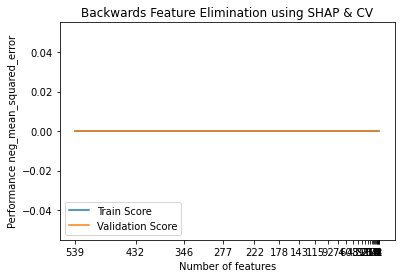

In [41]:
# Run feature elimination
shap_elimination = EarlyStoppingShapRFECV(
    clf=model, step=0.2, cv=10, scoring='neg_mean_squared_error', early_stopping_rounds=15, n_jobs=-1, eval_metric='rmse')
report = shap_elimination.fit_compute(X_XGB, np.log1p(y))

# Make plots
performance_plot = shap_elimination.plot()

In [42]:
report

,num_features,features_set,eliminated_features,train_metric_mean,train_metric_std,val_metric_mean,val_metric_std
1,539,"[12_temp_para65, 13_time_para30, 13_time_para4...","[18_gas_para33, 06_time_para34, 13_efem_para25...",-0.0,0.0,-0.0,0.0
2,432,"[12_temp_para65, 20_power_para57, 06_power_par...","[06_tmp_para31, 13_time_para67, module_name_45...",-0.0,0.0,-0.0,0.0
3,346,"[12_temp_para65, 06_power_para57, 13_time_para...","[module_name_eq_9, module_name_4, 04_temp_para...",-0.0,0.0,-0.0,0.0
4,277,"[12_temp_para65, 13_time_para43, 20_time_para3...","[04_position_para72, 20_time_para41, 04_time_p...",-0.0,0.0,-0.0,0.0
5,222,"[12_temp_para65, 13_time_para43, 13_time_para7...","[module_name_30, 17_efem_para25, 20_temp_para5...",-0.0,0.0,-0.0,0.0
6,178,"[12_temp_para65, 13_gas_para73, 12_temp_para12...","[13_time_para43, 13_gas_para73, 06_gas_para6, ...",-0.0,0.0,-0.0,0.0
7,143,"[12_temp_para65, 04_temp_para65, 13_time_para2...","[module_name_7, 20_time_para29, 12_pressure_pa...",-0.0,0.0,-0.0,0.0
8,115,"[12_temp_para65, 13_time_para29, 18_fr_para35,...","[04_time_para9, 20_time_para7, 17_fr_para61, 2...",-0.0,0.0,-0.0,0.0
9,92,"[12_temp_para65, 13_time_para29, 18_fr_para35,...","[13_gas_para21, 04_tmp_para31, 17_power_para76...",-0.0,0.0,-0.0,0.0
10,74,"[12_temp_para65, 13_time_para29, 18_fr_para35,...","[12_temp_para32, 06_temp_para65, 13_gas_para52...",-0.0,0.0,-0.0,0.0


In [62]:
# Get final feature set
''' num_features는 마지막에 남길 feature 수임. '''
final_features_set = shap_elimination.get_reduced_features_set(num_features=69)

The provided number of features has not been achieved at any stage of the process. You can select one of the following: [402, 322, 258, 207, 166, 133, 107, 86, 69, 56, 45, 36, 29, 24, 20, 16, 13, 11, 9, 8, 7, 6, 5, 4, 3, 2, 1]

In [63]:
final_features_set

['18_hv_para56',
 '13_efem_para78',
 'module_name_31',
 '06_time_para34',
 '06_gas_para6',
 '06_temp_para66',
 '13_time_para83',
 '04_temp_para38',
 '13_temp_para60',
 '18_time_para37',
 '04_efem_para78',
 '18_hv_para3',
 '20_efem_para78',
 '20_temp_para18',
 '18_time_para75',
 '20_gas_para33',
 'module_name_11',
 '04_power_para76',
 '06_temp_para53',
 '13_tmp_para31',
 '13_temp_para12',
 'module_name_8',
 '06_temp_para87',
 '04_time_para83',
 '06_gas_para73',
 '13_gas_para52',
 '18_fr_para61',
 '06_he_para22',
 '06_temp_para54',
 '18_temp_para18',
 '20_time_para44',
 '04_gas_para52',
 '20_temp_para11',
 '20_temp_para87',
 '20_gas_para59',
 '20_temp_para65',
 '06_time_para41',
 '04_time_para77',
 '06_power_para76',
 '20_temp_para53',
 '18_time_para16',
 'module_name_27',
 '04_efem_para2',
 '18_gas_para33',
 'module_name_39',
 'module_name_7',
 '20_temp_para17',
 '18_temp_para60',
 '20_time_para30',
 '13_power_para76',
 '18_time_para64',
 'module_name_eq_1',
 '13_temp_para86',
 '04_time

In [64]:
# mean_squared_error 의 매개변수 squared 가 False 이면 RMSE 를 반환합니다.
def rmse(y_true, y_pred):
    return round(mean_squared_error(y_true, y_pred, squared=False), 4)

def objective(trial):
    params_xgb = {
        'optimizer':trial.suggest_categorical('optimizer',['gbtree','gblinear','dart']),
        "lambda_l1": trial.suggest_int("lambda_l1", 0, 100, step=5),
        "lambda_l2": trial.suggest_int("lambda_l2", 0, 100, step=5),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.008,0.01,0.012,0.014,0.016,0.018, 0.02]),
        'n_estimators': 10000,
        'max_depth': trial.suggest_categorical('max_depth', [5,7,9,11,13,15,17]),
        'random_state': trial.suggest_categorical('random_state', [2022]),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.2, 0.9, step=0.1 ),
    }
    
    # 학습 데이터 중 일부를 검증 데이터 셋으로 분할합니다. 
    X_train, X_valid, y_train, y_valid = train_test_split(X_XGB[final_features_set], np.log1p(y), test_size=0.1, random_state=71)

    model = xgb.XGBRegressor(**params_xgb)
    model.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        early_stopping_rounds=35,
        verbose=False
    )

    xgb_pred = model.predict(X_valid)
    rmse_val = rmse(y_valid, xgb_pred)
    
    return rmse_val

In [65]:
sampler = TPESampler(seed=42)
study = optuna.create_study(
    study_name="xgb_parameter_opt",
    direction="minimize",
    sampler=sampler,
)
study.optimize(objective, n_trials=30)
print("Best Score:", study.best_value)
print("Best trial:", study.best_trial.params)

[I 2022-07-04 14:21:16,254] A new study created in memory with name: xgb_parameter_opt


[14:21:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "feature_fraction", "lambda_l1", "lambda_l2", "optimizer" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2022-07-04 14:21:16,707] Trial 0 finished with value: 0.0058 and parameters: {'optimizer': 'gblinear', 'lambda_l1': 60, 'lambda_l2': 15, 'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.02, 'max_depth': 13, 'random_state': 2022, 'min_child_weight': 285, 'feature_fraction': 0.9}. Best is trial 0 with value: 0.0058.


[14:21:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "feature_fraction", "lambda_l1", "lambda_l2", "optimizer" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2022-07-04 14:21:17,725] Trial 1 finished with value: 0.0057 and parameters: {'optimizer': 'gbtree', 'lambda_l1': 70, 'lambda_l2': 45, 'colsample_bytree': 0.6, 'subsample': 0.6, 'learning_rate': 0.01, 'max_depth': 7, 'random_state': 2022, 'min_child_weight': 23, 'feature_fraction': 0.9}. Best is trial 1 with value: 0.0057.


[14:21:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "feature_fraction", "lambda_l1", "lambda_l2", "optimizer" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2022-07-04 14:21:18,215] Trial 2 finished with value: 0.0057 and parameters: {'optimizer': 'gbtree', 'lambda_l1': 85, 'lambda_l2': 70, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.018, 'max_depth': 15, 'random_state': 2022, 'min_child_weight': 153, 'feature_fraction': 0.9}. Best is trial 1 with value: 0.0057.


[14:21:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "feature_fraction", "lambda_l1", "lambda_l2", "optimizer" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2022-07-04 14:21:18,807] Trial 3 finished with value: 0.0057 and parameters: {'optimizer': 'dart', 'lambda_l1': 20, 'lambda_l2': 5, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.014, 'max_depth': 11, 'random_state': 2022, 'min_child_weight': 110, 'feature_fraction': 0.9}. Best is trial 1 with value: 0.0057.


[14:21:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "feature_fraction", "lambda_l1", "lambda_l2", "optimizer" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2022-07-04 14:21:19,243] Trial 4 finished with value: 0.0057 and parameters: {'optimizer': 'gbtree', 'lambda_l1': 30, 'lambda_l2': 25, 'colsample_bytree': 0.8, 'subsample': 0.5, 'learning_rate': 0.02, 'max_depth': 13, 'random_state': 2022, 'min_child_weight': 68, 'feature_fraction': 0.7}. Best is trial 1 with value: 0.0057.


[14:21:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "feature_fraction", "lambda_l1", "lambda_l2", "optimizer" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2022-07-04 14:21:20,388] Trial 5 finished with value: 0.006 and parameters: {'optimizer': 'gblinear', 'lambda_l1': 95, 'lambda_l2': 10, 'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.014, 'max_depth': 9, 'random_state': 2022, 'min_child_weight': 2, 'feature_fraction': 0.30000000000000004}. Best is trial 1 with value: 0.0057.


[14:21:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "feature_fraction", "lambda_l1", "lambda_l2", "optimizer" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2022-07-04 14:21:21,268] Trial 6 finished with value: 0.0057 and parameters: {'optimizer': 'gblinear', 'lambda_l1': 20, 'lambda_l2': 70, 'colsample_bytree': 0.7, 'subsample': 0.7, 'learning_rate': 0.01, 'max_depth': 15, 'random_state': 2022, 'min_child_weight': 112, 'feature_fraction': 0.2}. Best is trial 1 with value: 0.0057.


[14:21:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "feature_fraction", "lambda_l1", "lambda_l2", "optimizer" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2022-07-04 14:21:22,313] Trial 7 finished with value: 0.0058 and parameters: {'optimizer': 'dart', 'lambda_l1': 100, 'lambda_l2': 85, 'colsample_bytree': 0.9, 'subsample': 0.7, 'learning_rate': 0.008, 'max_depth': 9, 'random_state': 2022, 'min_child_weight': 211, 'feature_fraction': 0.8}. Best is trial 1 with value: 0.0057.


[14:21:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "feature_fraction", "lambda_l1", "lambda_l2", "optimizer" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2022-07-04 14:21:22,746] Trial 8 finished with value: 0.0058 and parameters: {'optimizer': 'gbtree', 'lambda_l1': 5, 'lambda_l2': 60, 'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.02, 'max_depth': 9, 'random_state': 2022, 'min_child_weight': 289, 'feature_fraction': 0.8}. Best is trial 1 with value: 0.0057.


[14:21:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "feature_fraction", "lambda_l1", "lambda_l2", "optimizer" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2022-07-04 14:21:23,432] Trial 9 finished with value: 0.0057 and parameters: {'optimizer': 'gbtree', 'lambda_l1': 15, 'lambda_l2': 25, 'colsample_bytree': 0.7, 'subsample': 0.7, 'learning_rate': 0.012, 'max_depth': 15, 'random_state': 2022, 'min_child_weight': 113, 'feature_fraction': 0.7}. Best is trial 1 with value: 0.0057.


[14:21:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "feature_fraction", "lambda_l1", "lambda_l2", "optimizer" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2022-07-04 14:21:24,654] Trial 10 finished with value: 0.0058 and parameters: {'optimizer': 'gbtree', 'lambda_l1': 65, 'lambda_l2': 40, 'colsample_bytree': 0.6, 'subsample': 0.6, 'learning_rate': 0.01, 'max_depth': 7, 'random_state': 2022, 'min_child_weight': 4, 'feature_fraction': 0.5}. Best is trial 1 with value: 0.0057.


[14:21:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "feature_fraction", "lambda_l1", "lambda_l2", "optimizer" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2022-07-04 14:21:25,163] Trial 11 finished with value: 0.0057 and parameters: {'optimizer': 'gbtree', 'lambda_l1': 80, 'lambda_l2': 95, 'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.018, 'max_depth': 7, 'random_state': 2022, 'min_child_weight': 196, 'feature_fraction': 0.5}. Best is trial 1 with value: 0.0057.


[14:21:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "feature_fraction", "lambda_l1", "lambda_l2", "optimizer" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2022-07-04 14:21:25,650] Trial 12 finished with value: 0.0058 and parameters: {'optimizer': 'gbtree', 'lambda_l1': 80, 'lambda_l2': 45, 'colsample_bytree': 0.3, 'subsample': 0.4, 'learning_rate': 0.018, 'max_depth': 5, 'random_state': 2022, 'min_child_weight': 180, 'feature_fraction': 0.7}. Best is trial 1 with value: 0.0057.


[14:21:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "feature_fraction", "lambda_l1", "lambda_l2", "optimizer" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2022-07-04 14:21:26,410] Trial 13 finished with value: 0.0057 and parameters: {'optimizer': 'gbtree', 'lambda_l1': 50, 'lambda_l2': 70, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.016, 'max_depth': 17, 'random_state': 2022, 'min_child_weight': 55, 'feature_fraction': 0.9}. Best is trial 1 with value: 0.0057.


[14:21:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "feature_fraction", "lambda_l1", "lambda_l2", "optimizer" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2022-07-04 14:21:26,944] Trial 14 finished with value: 0.0058 and parameters: {'optimizer': 'gbtree', 'lambda_l1': 80, 'lambda_l2': 60, 'colsample_bytree': 0.6, 'subsample': 0.6, 'learning_rate': 0.018, 'max_depth': 7, 'random_state': 2022, 'min_child_weight': 237, 'feature_fraction': 0.6000000000000001}. Best is trial 1 with value: 0.0057.


[14:21:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "feature_fraction", "lambda_l1", "lambda_l2", "optimizer" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2022-07-04 14:21:27,934] Trial 15 finished with value: 0.0056 and parameters: {'optimizer': 'dart', 'lambda_l1': 50, 'lambda_l2': 80, 'colsample_bytree': 0.8, 'subsample': 0.6, 'learning_rate': 0.01, 'max_depth': 15, 'random_state': 2022, 'min_child_weight': 150, 'feature_fraction': 0.8}. Best is trial 15 with value: 0.0056.


[14:21:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "feature_fraction", "lambda_l1", "lambda_l2", "optimizer" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2022-07-04 14:21:28,789] Trial 16 finished with value: 0.0057 and parameters: {'optimizer': 'dart', 'lambda_l1': 40, 'lambda_l2': 100, 'colsample_bytree': 0.6, 'subsample': 0.6, 'learning_rate': 0.01, 'max_depth': 11, 'random_state': 2022, 'min_child_weight': 61, 'feature_fraction': 0.8}. Best is trial 15 with value: 0.0056.


[14:21:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "feature_fraction", "lambda_l1", "lambda_l2", "optimizer" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2022-07-04 14:21:29,645] Trial 17 finished with value: 0.0058 and parameters: {'optimizer': 'dart', 'lambda_l1': 45, 'lambda_l2': 100, 'colsample_bytree': 0.3, 'subsample': 0.6, 'learning_rate': 0.01, 'max_depth': 11, 'random_state': 2022, 'min_child_weight': 76, 'feature_fraction': 0.6000000000000001}. Best is trial 15 with value: 0.0056.


[14:21:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "feature_fraction", "lambda_l1", "lambda_l2", "optimizer" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2022-07-04 14:21:30,461] Trial 18 finished with value: 0.0058 and parameters: {'optimizer': 'dart', 'lambda_l1': 65, 'lambda_l2': 35, 'colsample_bytree': 0.4, 'subsample': 0.6, 'learning_rate': 0.01, 'max_depth': 5, 'random_state': 2022, 'min_child_weight': 245, 'feature_fraction': 0.4}. Best is trial 15 with value: 0.0056.


[14:21:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "feature_fraction", "lambda_l1", "lambda_l2", "optimizer" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2022-07-04 14:21:31,173] Trial 19 finished with value: 0.0056 and parameters: {'optimizer': 'dart', 'lambda_l1': 0, 'lambda_l2': 20, 'colsample_bytree': 0.7, 'subsample': 0.5, 'learning_rate': 0.012, 'max_depth': 15, 'random_state': 2022, 'min_child_weight': 128, 'feature_fraction': 0.7}. Best is trial 15 with value: 0.0056.


[14:21:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "feature_fraction", "lambda_l1", "lambda_l2", "optimizer" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2022-07-04 14:21:31,908] Trial 20 finished with value: 0.0058 and parameters: {'optimizer': 'dart', 'lambda_l1': 0, 'lambda_l2': 0, 'colsample_bytree': 0.7, 'subsample': 0.5, 'learning_rate': 0.012, 'max_depth': 15, 'random_state': 2022, 'min_child_weight': 151, 'feature_fraction': 0.6000000000000001}. Best is trial 15 with value: 0.0056.


[14:21:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "feature_fraction", "lambda_l1", "lambda_l2", "optimizer" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2022-07-04 14:21:32,773] Trial 21 finished with value: 0.0057 and parameters: {'optimizer': 'dart', 'lambda_l1': 35, 'lambda_l2': 30, 'colsample_bytree': 1.0, 'subsample': 0.5, 'learning_rate': 0.012, 'max_depth': 15, 'random_state': 2022, 'min_child_weight': 32, 'feature_fraction': 0.8}. Best is trial 15 with value: 0.0056.


[14:21:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "feature_fraction", "lambda_l1", "lambda_l2", "optimizer" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2022-07-04 14:21:33,624] Trial 22 finished with value: 0.0056 and parameters: {'optimizer': 'dart', 'lambda_l1': 35, 'lambda_l2': 25, 'colsample_bytree': 1.0, 'subsample': 0.5, 'learning_rate': 0.012, 'max_depth': 15, 'random_state': 2022, 'min_child_weight': 133, 'feature_fraction': 0.7}. Best is trial 15 with value: 0.0056.


[14:21:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "feature_fraction", "lambda_l1", "lambda_l2", "optimizer" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2022-07-04 14:21:34,487] Trial 23 finished with value: 0.0056 and parameters: {'optimizer': 'dart', 'lambda_l1': 10, 'lambda_l2': 20, 'colsample_bytree': 1.0, 'subsample': 0.5, 'learning_rate': 0.012, 'max_depth': 15, 'random_state': 2022, 'min_child_weight': 127, 'feature_fraction': 0.7}. Best is trial 15 with value: 0.0056.


[14:21:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "feature_fraction", "lambda_l1", "lambda_l2", "optimizer" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2022-07-04 14:21:35,197] Trial 24 finished with value: 0.0058 and parameters: {'optimizer': 'dart', 'lambda_l1': 10, 'lambda_l2': 15, 'colsample_bytree': 0.7, 'subsample': 0.5, 'learning_rate': 0.012, 'max_depth': 15, 'random_state': 2022, 'min_child_weight': 177, 'feature_fraction': 0.7}. Best is trial 15 with value: 0.0056.


[14:21:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "feature_fraction", "lambda_l1", "lambda_l2", "optimizer" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2022-07-04 14:21:35,748] Trial 25 finished with value: 0.0058 and parameters: {'optimizer': 'dart', 'lambda_l1': 55, 'lambda_l2': 55, 'colsample_bytree': 0.8, 'subsample': 0.4, 'learning_rate': 0.016, 'max_depth': 17, 'random_state': 2022, 'min_child_weight': 136, 'feature_fraction': 0.8}. Best is trial 15 with value: 0.0056.


[14:21:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "feature_fraction", "lambda_l1", "lambda_l2", "optimizer" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2022-07-04 14:21:36,452] Trial 26 finished with value: 0.0057 and parameters: {'optimizer': 'dart', 'lambda_l1': 0, 'lambda_l2': 85, 'colsample_bytree': 1.0, 'subsample': 0.5, 'learning_rate': 0.012, 'max_depth': 15, 'random_state': 2022, 'min_child_weight': 99, 'feature_fraction': 0.6000000000000001}. Best is trial 15 with value: 0.0056.


[14:21:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "feature_fraction", "lambda_l1", "lambda_l2", "optimizer" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2022-07-04 14:21:37,169] Trial 27 finished with value: 0.0057 and parameters: {'optimizer': 'dart', 'lambda_l1': 25, 'lambda_l2': 20, 'colsample_bytree': 1.0, 'subsample': 0.5, 'learning_rate': 0.012, 'max_depth': 15, 'random_state': 2022, 'min_child_weight': 89, 'feature_fraction': 0.5}. Best is trial 15 with value: 0.0056.


[14:21:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "feature_fraction", "lambda_l1", "lambda_l2", "optimizer" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2022-07-04 14:21:37,912] Trial 28 finished with value: 0.0056 and parameters: {'optimizer': 'dart', 'lambda_l1': 10, 'lambda_l2': 0, 'colsample_bytree': 1.0, 'subsample': 0.5, 'learning_rate': 0.012, 'max_depth': 15, 'random_state': 2022, 'min_child_weight': 134, 'feature_fraction': 0.7}. Best is trial 15 with value: 0.0056.


[14:21:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "feature_fraction", "lambda_l1", "lambda_l2", "optimizer" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2022-07-04 14:21:39,048] Trial 29 finished with value: 0.0057 and parameters: {'optimizer': 'gblinear', 'lambda_l1': 35, 'lambda_l2': 0, 'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.008, 'max_depth': 13, 'random_state': 2022, 'min_child_weight': 162, 'feature_fraction': 0.8}. Best is trial 15 with value: 0.0056.


Best Score: 0.0056
Best trial: {'optimizer': 'dart', 'lambda_l1': 50, 'lambda_l2': 80, 'colsample_bytree': 0.8, 'subsample': 0.6, 'learning_rate': 0.01, 'max_depth': 15, 'random_state': 2022, 'min_child_weight': 150, 'feature_fraction': 0.8}


# 예측 결과 제출

In [249]:
df_predict.head()

,module_name,key_val,04_temp_para86,04_time_para8,13_time_para90,17_position_para72,17_temp_para66,20_temp_para86,17_gas_para33,06_time_para67,...,18_end_time,20_end_time,module_name_eq,gen_tmdiff,gen_tmdiff_0406,gen_tmdiff_0612,gen_tmdiff_1213,gen_tmdiff_1317,gen_tmdiff_1718,gen_tmdiff_1820
0,0,LOT380_17,22.056250,37.800000,37.85000,16.366667,90.01755,25.906235,0.0,2965.1000,...,2021-10-28 08:39:22,2021-10-28 08:46:13,0,1837.0,123.0,795.0,16.0,476.0,16.0,411.0
1,0,LOT122_18,22.041930,63.233330,63.28333,16.314820,90.01404,25.912940,0.0,2990.5330,...,2021-10-29 12:12:57,2021-10-29 12:19:48,0,1838.0,122.0,796.0,16.0,477.0,16.0,411.0
2,0,LOT313_18,22.018750,73.650000,73.70000,16.392593,89.99298,25.919651,0.0,3000.9500,...,2021-10-29 23:29:36,2021-10-29 23:36:27,0,1838.0,122.0,796.0,16.0,477.0,16.0,411.0
3,0,LOT459_12,22.072727,98.083336,98.13333,16.396296,90.01579,25.951250,0.0,3025.3833,...,2021-10-31 04:03:35,2021-10-31 04:10:25,0,1843.0,123.0,801.0,16.0,477.0,16.0,410.0
4,0,LOT459_18,22.012903,99.250000,99.30000,16.394444,90.00702,25.963840,0.0,3026.5500,...,2021-10-31 05:19:01,2021-10-31 05:25:52,0,1841.0,121.0,801.0,16.0,476.0,16.0,411.0


In [248]:
df_predict.loc[:,num_features] = (df_predict.loc[:,num_features] - means[0])/stds[0]

KeyError: "Passing list-likes to .loc or [] with any missing labels is no longer supported. The following labels were missing: Index(['efem_para2_pca0', 'efem_para25_pca0', 'efem_para78_pca0',\n       'esc_para94_pca0', 'fr_para61_pca0',\n       ...\n       'temp_para92_pca0', 'temp_para92_pca1', 'temp_para55_pca0',\n       'temp_para55_pca1', 'temp_para55_pca2'],\n      dtype='object', length=55). See https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike"

In [55]:
pred_X = pd.get_dummies(df_predict[COLS])

In [63]:
predict['msure_val'] = np.exp(model.predict(pred_X))
df_submission = predict[['key_val', 'msure_val']] 
df_submission.head()

,key_val,msure_val
0,LOT380_17,1265.629272
1,LOT122_18,1260.781982
2,LOT313_18,1265.418457
3,LOT459_12,1257.380493
4,LOT459_18,1257.193359


In [57]:
# 예측값에 결측치가 포함되어 있는지 확인합니다.
df_submission.isnull().sum()

key_val      0
msure_val    0
dtype: int64

In [58]:
# 예측값의 갯수가 평가용 데이터의 갯수와 동일한지 확인합니다.
assert len(df_submission) == len(predict)
print(f'No. of Predict DataSet : {len(predict)}\nNo. of Submission DataSet : {len(df_submission)}')

No. of Predict DataSet : 262
No. of Submission DataSet : 262


In [64]:
# 예측 파일을 저장합니다. 
# 제출용 파일 이름은 cds_submission_팀명_차수.csv 형태로 제출합니다.
df_submission.set_index('key_val', inplace=True)
df_submission.to_csv('cds_submission_데이터조무사_7.csv')

In [ ]:
cv 하는거 참조
https://dacon.io/en/competitions/official/235877/codeshare/4710

In [ ]:
step4 : ['gas_para21','gas_para36','gas_para59','gas_para6','he_para22','he_para88','position_para72','power_para76','pressure_para91','temp_para12','temp_para18','temp_para20','temp_para38','temp_para54','temp_para60','temp_para65','temp_para86','time_para16','time_para29','time_para30','time_para34','time_para37','time_para41','time_para42','time_para43','time_para62','time_para64','time_para67','time_para7','time_para75','time_para77','time_para8','time_para81','time_para83','time_para89','time_para9','time_para90','tmp_para31']
step6 : ['epd_para4','epd_para63','esc_para94','gas_para23','gas_para26','gas_para36','gas_para6','he_para22','he_para88','position_para72','power_para49','power_para57','power_para76','temp_para12','temp_para18','temp_para20','temp_para38','temp_para54','temp_para58','temp_para60','temp_para65','temp_para86','time_para16','time_para29','time_para30','time_para34','time_para37','time_para41','time_para42','time_para43','time_para62','time_para64','time_para67','time_para7','time_para75','time_para77','time_para8','time_para81','time_para83','time_para9','time_para90','tmp_para31']
step12 : ['gas_para21','gas_para36','gas_para6','gas_para73','he_para22','he_para88','hv_para45','hv_para47','hv_para56','position_para72','power_para14','temp_para12','temp_para18','temp_para20','temp_para24','temp_para38','temp_para60','temp_para65','temp_para86','time_para16','time_para29','time_para30','time_para34','time_para37','time_para41','time_para42','time_para43','time_para5','time_para62','time_para64','time_para67','time_para7','time_para75','time_para77','time_para8','time_para81','time_para83','time_para9','time_para90','tmp_para31']
step13 : ['gas_para21','gas_para36','gas_para59','gas_para6','gas_para73','he_para22','he_para88','hv_para45','hv_para47','hv_para56','position_para72','power_para14','power_para76','power_para82','temp_para18','temp_para20','temp_para24','temp_para38','temp_para60','temp_para65','temp_para86','time_para16','time_para29','time_para30','time_para34','time_para37','time_para41','time_para42','time_para43','time_para5','time_para62','time_para64','time_para67','time_para7','time_para75','time_para77','time_para8','time_para81','time_para83','time_para9','time_para90','tmp_para31']
step17 : ['fr_para28','fr_para69','gas_para21','gas_para36','gas_para59','gas_para6','gas_para73','he_para22','he_para88','position_para72','power_para14','power_para76','power_para82','temp_para12','temp_para18','temp_para20','temp_para24','temp_para38','temp_para60','temp_para65','temp_para86','time_para16','time_para29','time_para30','time_para34','time_para37','time_para41','time_para42','time_para43','time_para5','time_para62','time_para64','time_para67','time_para7','time_para75','time_para77','time_para8','time_para81','time_para83','time_para9','time_para90','tmp_para31']
step18 : []

# PYCARET 용

In [67]:
pred['Label']

,17_pressure_para91,12_gas_para26,17_temp_para32,06_gas_para26,04_gas_para26,13_gas_para52,20_gas_para26,13_temp_para32,18_temp_para32,20_gas_para73,...,module_name_eq_3,module_name_eq_4,module_name_eq_5,module_name_eq_6,module_name_eq_7,module_name_eq_8,module_name_eq_9,module_name_eq_10,module_name_eq_11,Label
0,0.102933,1.133793,-1.008070,0.193044,-0.691354,0.526658,0.759050,0.419387,-0.895134,-0.179310,...,0,0,0,0,0,0,0,0,0,1263.050330
1,0.104847,-0.446933,0.174962,-0.188963,-0.027962,-1.929976,0.831439,-0.515447,0.177806,0.380726,...,0,0,0,0,0,0,0,0,0,1262.358214
2,-0.782996,1.246835,-0.163199,0.191364,0.078791,2.061944,1.942678,0.575196,-0.442715,0.068077,...,0,0,0,0,0,0,0,0,0,1261.775813
3,0.102933,-1.915237,0.174673,-0.570130,0.178150,2.983224,0.494893,0.107749,-1.218331,0.489824,...,0,0,0,0,0,0,0,0,0,1261.710770
4,0.102933,-0.898791,0.005641,0.384047,-2.019527,0.526658,-0.864375,-0.048060,-0.752965,0.579472,...,0,0,0,0,0,0,0,0,0,1262.698655
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257,0.988863,-0.673017,0.681625,0.578199,-0.691354,0.219621,0.704441,-1.294594,0.022651,-1.437574,...,0,0,0,0,0,0,0,0,1,1260.958137
258,-0.784909,-0.446933,-0.501167,0.575050,1.233663,0.526658,-0.068982,-0.203910,-0.287620,0.109544,...,0,0,0,0,0,0,0,0,1,1260.230169
259,1.874792,0.117656,0.850513,-0.570130,0.550861,0.219621,0.482193,0.419387,0.488017,0.257312,...,0,0,0,0,0,0,0,0,1,1260.390879
260,-0.782996,-0.559975,0.512641,-0.760504,-0.306397,0.526658,-0.036978,-0.359699,0.177766,0.439307,...,0,0,0,0,0,0,0,0,1,1260.697004


In [68]:
predict['msure_val'] = pred['Label']
df_submission = predict[['key_val', 'msure_val']] 
df_submission.head()

,key_val,msure_val
0,LOT380_17,1263.050330
1,LOT122_18,1262.358214
2,LOT313_18,1261.775813
3,LOT459_12,1261.710770
4,LOT459_18,1262.698655


In [69]:
df_submission.set_index('key_val', inplace=True)
df_submission.to_csv('cds_submission_데이터조무사_8.csv')

In [70]:
df_submission.isnull().sum()
# 예측값의 갯수가 평가용 데이터의 갯수와 동일한지 확인합니다.
assert len(df_submission) == len(predict)
print(f'No. of Predict DataSet : {len(predict)}\nNo. of Submission DataSet : {len(df_submission)}')

No. of Predict DataSet : 262
No. of Submission DataSet : 262
